In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 16
        Out dimension MaxPooling:  112 * 112 * 16
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        )
        self.batch1 = nn.BatchNorm2d(16)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 16
        Out dimension Conv:        112 * 112 * 32
        Out dimension MaxPooling:  56  * 56  * 32
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.batch2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 32
        Out dimension Conv:        56  * 56  * 64
        Out dimension MaxPooling:  28  * 28  * 64
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        ) 
        self.batch3 = nn.BatchNorm2d(64)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 64
        Out dimension Conv:        28  * 28  * 128
        Out dimension MaxPooling:  14  * 14  * 128
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.batch4 = nn.BatchNorm2d(128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              14  * 14  * 128
        Out dimension Conv:        14  * 14  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.batch5 = nn.BatchNorm2d(128)
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              7  * 7  * 128
        Out dimension Conv:        7  * 7  * 128
        Out dimension MaxPooling:  7  * 7  * 128
        '''
        self.cnn6_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.batch6 = nn.BatchNorm2d(128)
        
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=6272, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        # Convolution
        x = self.cnn1_model(x)
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        

        # Convolution
        x = self.cnn2_model(x)
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        
        # Convolution
        x = self.cnn3_model(x)
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        
        # Convolution
        x = self.cnn4_model(x)
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        # Convolution
        x = self.cnn5_model(x)
        x = self.batch5(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool5(x)
        
        
        # Convolution
        x = self.cnn6_model(x)
        x = self.batch6(x)
        x = F.relu(x) 
        
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 4794084


# Load Data

In [8]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [9]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [10]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [11]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [12]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [13]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [14]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-2.1179, -2.1179, -2.1179,  ...,  1.7009,  1.7009,  1.6838],
          [-2.1179, -2.1179, -2.1179,  ...,  1.6838,  1.6838,  1.6667],
          [-2.1179, -2.1179, -2.1179,  ...,  1.6495,  1.6495,  1.6667],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -0.7479, -0.8164, -0.8164],
          [-2.1179, -2.1179, -2.1179,  ..., -0.6794, -0.7308, -0.7137],
          [-2.1179, -2.1179, -2.1179,  ..., -0.6109, -0.6623, -0.6281]],

         [[-2.0357, -2.0357, -2.0357,  ...,  2.1660,  2.1660,  2.1485],
          [-2.0357, -2.0357, -2.0357,  ...,  2.1660,  2.1485,  2.1310],
          [-2.0357, -2.0357, -2.0357,  ...,  2.1485,  2.1310,  2.1134],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  0.5378,  0.4678,  0.4678],
          [-2.0357, -2.0357, -2.0357,  ...,  0.6254,  0.5553,  0.5728],
          [-2.0357, -2.0357, -2.0357,  ...,  0.64

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:03<00:00,  4.91it/s]


train loss:  0.075429619626796
Val loss:  0.16403165796528693
train accuracy:  0.5338491295938105
Val accuracy:  0.45217391304347826
Current time: 0.833 minutes. Time expected till completion: 415.812 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:01<00:00, 14.39it/s]


train loss:  0.07042989186668765
Val loss:  0.14237477001936538
train accuracy:  0.6025145067698259
Val accuracy:  0.6608695652173913
Current time: 1.194 minutes. Time expected till completion: 297.414 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:01<00:00, 14.08it/s]


train loss:  0.06962415714328478
Val loss:  0.1426312260005785
train accuracy:  0.5996131528046421
Val accuracy:  0.6434782608695652
Current time: 1.565 minutes. Time expected till completion: 259.329 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


train loss:  0.06896932719985106
Val loss:  0.15108958171761555
train accuracy:  0.6092843326885881
Val accuracy:  0.5304347826086957
Current time: 1.943 minutes. Time expected till completion: 240.894 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.06888171292596444
Val loss:  0.14197639589724334
train accuracy:  0.6054158607350096
Val accuracy:  0.6695652173913044
Current time: 2.327 minutes. Time expected till completion: 230.341 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.06868157839867317
Val loss:  0.1395786782969599
train accuracy:  0.6054158607350096
Val accuracy:  0.6608695652173913
Current time: 2.708 minutes. Time expected till completion: 222.999 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.06880740034511057
Val loss:  0.14174898603688116
train accuracy:  0.6083172147001934
Val accuracy:  0.6608695652173913
Current time: 3.094 minutes. Time expected till completion: 217.883 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  0.06850843290065198
Val loss:  0.1410206348999687
train accuracy:  0.6034816247582205
Val accuracy:  0.6695652173913044
Current time: 3.479 minutes. Time expected till completion: 213.952 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.0677083742803024
Val loss:  0.14036525798880536
train accuracy:  0.6218568665377177
Val accuracy:  0.6434782608695652
Current time: 3.870 minutes. Time expected till completion: 211.140 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.06816935804411337
Val loss:  0.14309342684953108
train accuracy:  0.6150870406189555
Val accuracy:  0.6260869565217392
Current time: 4.259 minutes. Time expected till completion: 208.687 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.06734424973594842
Val loss:  0.14135302460711935
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 4.650 minutes. Time expected till completion: 206.693 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.06833924701873292
Val loss:  0.1398745982543282
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 5.048 minutes. Time expected till completion: 205.302 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.06840665139819944
Val loss:  0.14082453665526018
train accuracy:  0.6092843326885881
Val accuracy:  0.6347826086956522
Current time: 5.439 minutes. Time expected till completion: 203.750 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.06808026524069692
Val loss:  0.14088194888571035
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 5.829 minutes. Time expected till completion: 202.339 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


train loss:  0.06779915561297876
Val loss:  0.13936510500700577
train accuracy:  0.6121856866537717
Val accuracy:  0.6956521739130435
Current time: 6.218 minutes. Time expected till completion: 201.047 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.06775362060425129
Val loss:  0.13884706238041752
train accuracy:  0.6160541586073501
Val accuracy:  0.6869565217391305
Current time: 6.608 minutes. Time expected till completion: 199.902 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  0.0675998246531422
Val loss:  0.1404165734415469
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 6.999 minutes. Time expected till completion: 198.865 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.067997717822774
Val loss:  0.1404925937237947
train accuracy:  0.6199226305609284
Val accuracy:  0.6782608695652174
Current time: 7.389 minutes. Time expected till completion: 197.859 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.06725581454354514
Val loss:  0.1403785026591757
train accuracy:  0.6121856866537717
Val accuracy:  0.6608695652173913
Current time: 7.783 minutes. Time expected till completion: 197.031 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:01<00:00, 13.84it/s]


train loss:  0.06770752523116032
Val loss:  0.14601127997688626
train accuracy:  0.6170212765957447
Val accuracy:  0.6347826086956522
Current time: 8.173 minutes. Time expected till completion: 196.151 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.06749455051449789
Val loss:  0.13903313719707985
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 8.564 minutes. Time expected till completion: 195.334 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.06719655386483876
Val loss:  0.1380510765573253
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 8.954 minutes. Time expected till completion: 194.542 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.06735810130200487
Val loss:  0.13846668160480002
train accuracy:  0.6121856866537717
Val accuracy:  0.6695652173913044
Current time: 9.344 minutes. Time expected till completion: 193.784 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.0672301532452065
Val loss:  0.13824988396271415
train accuracy:  0.6247582205029013
Val accuracy:  0.6695652173913044
Current time: 9.736 minutes. Time expected till completion: 193.093 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.06705672033059067
Val loss:  0.13807896064675373
train accuracy:  0.6141199226305609
Val accuracy:  0.6695652173913044
Current time: 10.126 minutes. Time expected till completion: 192.385 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06700845031028098
Val loss:  0.13809144496917725
train accuracy:  0.6286266924564797
Val accuracy:  0.6521739130434783
Current time: 10.517 minutes. Time expected till completion: 191.739 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


train loss:  0.06706573613838254
Val loss:  0.1374763452488443
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 10.906 minutes. Time expected till completion: 191.066 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:01<00:00, 13.50it/s]


train loss:  0.06749124724122496
Val loss:  0.14134028165236764
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 11.297 minutes. Time expected till completion: 190.437 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


train loss:  0.06762312194134326
Val loss:  0.13726704898087874
train accuracy:  0.6189555125725339
Val accuracy:  0.6695652173913044
Current time: 11.686 minutes. Time expected till completion: 189.792 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


train loss:  0.06711295477656838
Val loss:  0.1390891686729763
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 12.078 minutes. Time expected till completion: 189.217 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.06692117175926784
Val loss:  0.13755957821141118
train accuracy:  0.6266924564796905
Val accuracy:  0.6869565217391305
Current time: 12.467 minutes. Time expected till completion: 188.618 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:01<00:00, 13.43it/s]


train loss:  0.06680602031242916
Val loss:  0.13873893126197484
train accuracy:  0.6199226305609284
Val accuracy:  0.6695652173913044
Current time: 12.858 minutes. Time expected till completion: 188.046 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06694835043968038
Val loss:  0.13952850103378295
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 13.250 minutes. Time expected till completion: 187.511 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


train loss:  0.06691378453022276
Val loss:  0.13769443916237872
train accuracy:  0.6199226305609284
Val accuracy:  0.6869565217391305
Current time: 13.640 minutes. Time expected till completion: 186.951 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.06622699877279639
Val loss:  0.13715631236200748
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 14.031 minutes. Time expected till completion: 186.407 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.06722099436320926
Val loss:  0.13591089144996973
train accuracy:  0.6199226305609284
Val accuracy:  0.6782608695652174
Current time: 14.421 minutes. Time expected till completion: 185.865 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.06637587197975217
Val loss:  0.1376422000967938
train accuracy:  0.6247582205029013
Val accuracy:  0.6608695652173913
Current time: 14.814 minutes. Time expected till completion: 185.378 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.06675878495727332
Val loss:  0.13838107171265976
train accuracy:  0.6228239845261122
Val accuracy:  0.6608695652173913
Current time: 15.207 minutes. Time expected till completion: 184.885 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.0671292639101497
Val loss:  0.13665138223896856
train accuracy:  0.620889748549323
Val accuracy:  0.6782608695652174
Current time: 15.598 minutes. Time expected till completion: 184.373 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.06631805760717484
Val loss:  0.1367304890052132
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 15.989 minutes. Time expected till completion: 183.868 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.06678964171695524
Val loss:  0.1388704916705256
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 16.378 minutes. Time expected till completion: 183.355 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.06633221601609797
Val loss:  0.13749546952869582
train accuracy:  0.6247582205029013
Val accuracy:  0.6434782608695652
Current time: 16.769 minutes. Time expected till completion: 182.857 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.0667726470723143
Val loss:  0.1376420674116715
train accuracy:  0.6218568665377177
Val accuracy:  0.6521739130434783
Current time: 17.159 minutes. Time expected till completion: 182.363 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.0664229471402196
Val loss:  0.13795590245205422
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 17.550 minutes. Time expected till completion: 181.885 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:01<00:00, 13.50it/s]


train loss:  0.06688003360187524
Val loss:  0.13738743429598602
train accuracy:  0.6160541586073501
Val accuracy:  0.6782608695652174
Current time: 17.941 minutes. Time expected till completion: 181.402 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.06627050330376026
Val loss:  0.1370908965235171
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 18.331 minutes. Time expected till completion: 180.920 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.06591243641288876
Val loss:  0.13728706059248552
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 18.721 minutes. Time expected till completion: 180.436 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.06587698957675661
Val loss:  0.13918882090112436
train accuracy:  0.6237911025145068
Val accuracy:  0.6434782608695652
Current time: 19.111 minutes. Time expected till completion: 179.965 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:01<00:00, 13.50it/s]


train loss:  0.0663635078781578
Val loss:  0.13847690146902333
train accuracy:  0.6266924564796905
Val accuracy:  0.6782608695652174
Current time: 19.502 minutes. Time expected till completion: 179.495 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.06574980709953972
Val loss:  0.1387953291768613
train accuracy:  0.632495164410058
Val accuracy:  0.6608695652173913
Current time: 19.893 minutes. Time expected till completion: 179.041 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.06627630011486592
Val loss:  0.13868651597396187
train accuracy:  0.6199226305609284
Val accuracy:  0.6782608695652174
Current time: 20.283 minutes. Time expected till completion: 178.570 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.06602387110084815
Val loss:  0.13797825626705004
train accuracy:  0.6295938104448743
Val accuracy:  0.6521739130434783
Current time: 20.678 minutes. Time expected till completion: 178.147 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.06639140711762227
Val loss:  0.13781440724497257
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 21.068 minutes. Time expected till completion: 177.684 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.06645414411906347
Val loss:  0.13966576431108557
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 21.459 minutes. Time expected till completion: 177.237 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06589251053402456
Val loss:  0.1365815193756767
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 21.849 minutes. Time expected till completion: 176.778 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.0659162812007004
Val loss:  0.13719820302465688
train accuracy:  0.6247582205029013
Val accuracy:  0.7304347826086957
Current time: 22.242 minutes. Time expected till completion: 176.344 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.06572016232018314
Val loss:  0.1428089090015577
train accuracy:  0.6237911025145068
Val accuracy:  0.5304347826086957
Current time: 22.633 minutes. Time expected till completion: 175.904 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.06598858249948379
Val loss:  0.13898327868917715
train accuracy:  0.6112185686653772
Val accuracy:  0.6434782608695652
Current time: 23.023 minutes. Time expected till completion: 175.454 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.06550536775957916
Val loss:  0.13606101533640985
train accuracy:  0.6305609284332688
Val accuracy:  0.6956521739130435
Current time: 23.412 minutes. Time expected till completion: 174.997 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:01<00:00, 13.26it/s]


train loss:  0.06573341293999029
Val loss:  0.13586993217468263
train accuracy:  0.6247582205029013
Val accuracy:  0.6956521739130435
Current time: 23.804 minutes. Time expected till completion: 174.562 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.06573644003738979
Val loss:  0.13678715073544045
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 24.195 minutes. Time expected till completion: 174.124 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.06602325574341779
Val loss:  0.13853056430816652
train accuracy:  0.6266924564796905
Val accuracy:  0.6956521739130435
Current time: 24.585 minutes. Time expected till completion: 173.679 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:01<00:00, 13.75it/s]


train loss:  0.0655360035670334
Val loss:  0.1366126283355381
train accuracy:  0.6315280464216635
Val accuracy:  0.6695652173913044
Current time: 24.974 minutes. Time expected till completion: 173.231 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.06540854306931192
Val loss:  0.13920996655588563
train accuracy:  0.6315280464216635
Val accuracy:  0.6608695652173913
Current time: 25.364 minutes. Time expected till completion: 172.790 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.06557338582477902
Val loss:  0.13580248770506487
train accuracy:  0.6266924564796905
Val accuracy:  0.7043478260869566
Current time: 25.754 minutes. Time expected till completion: 172.351 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.06559731899193223
Val loss:  0.13489857341932213
train accuracy:  0.6228239845261122
Val accuracy:  0.6956521739130435
Current time: 26.144 minutes. Time expected till completion: 171.913 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.06520147209471845
Val loss:  0.13691720236902652
train accuracy:  0.6382978723404256
Val accuracy:  0.6695652173913044
Current time: 26.535 minutes. Time expected till completion: 171.486 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.06547133408385965
Val loss:  0.138420133487038
train accuracy:  0.6353965183752418
Val accuracy:  0.6608695652173913
Current time: 26.925 minutes. Time expected till completion: 171.053 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.06547005137345777
Val loss:  0.13776397912398627
train accuracy:  0.6344294003868471
Val accuracy:  0.6782608695652174
Current time: 27.317 minutes. Time expected till completion: 170.633 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06562162950144976
Val loss:  0.13650593135667885
train accuracy:  0.6295938104448743
Val accuracy:  0.7043478260869566
Current time: 27.708 minutes. Time expected till completion: 170.206 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.06511909075124582
Val loss:  0.13524159659510074
train accuracy:  0.6373307543520309
Val accuracy:  0.6869565217391305
Current time: 28.100 minutes. Time expected till completion: 169.786 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06525042134281284
Val loss:  0.13588795195455136
train accuracy:  0.6363636363636364
Val accuracy:  0.6608695652173913
Current time: 28.494 minutes. Time expected till completion: 169.379 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.06564637828380504
Val loss:  0.1385402710541435
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 28.884 minutes. Time expected till completion: 168.950 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.06524095550265949
Val loss:  0.13890462647313656
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 29.273 minutes. Time expected till completion: 168.517 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:01<00:00, 13.49it/s]


train loss:  0.06508854290964064
Val loss:  0.13985065480937128
train accuracy:  0.632495164410058
Val accuracy:  0.6347826086956522
Current time: 29.663 minutes. Time expected till completion: 168.088 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:01<00:00, 13.84it/s]


train loss:  0.06558597099389052
Val loss:  0.13513557444448057
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 30.054 minutes. Time expected till completion: 167.668 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.0655365596656873
Val loss:  0.1378756803015004
train accuracy:  0.6421663442940039
Val accuracy:  0.6869565217391305
Current time: 30.443 minutes. Time expected till completion: 167.238 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.06496151958950715
Val loss:  0.13752418134523475
train accuracy:  0.6411992263056093
Val accuracy:  0.6956521739130435
Current time: 30.833 minutes. Time expected till completion: 166.814 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


train loss:  0.0647226974973365
Val loss:  0.1343980830648671
train accuracy:  0.6402321083172147
Val accuracy:  0.6869565217391305
Current time: 31.222 minutes. Time expected till completion: 166.384 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.06517830929165883
Val loss:  0.14093312958012458
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 31.613 minutes. Time expected till completion: 165.968 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.06477294819036812
Val loss:  0.13812598404677018
train accuracy:  0.6382978723404256
Val accuracy:  0.6608695652173913
Current time: 32.002 minutes. Time expected till completion: 165.543 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.06430152191184245
Val loss:  0.13752482974010966
train accuracy:  0.6576402321083172
Val accuracy:  0.6695652173913044
Current time: 32.394 minutes. Time expected till completion: 165.131 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  0.06464081645242481
Val loss:  0.13768724773241126
train accuracy:  0.6373307543520309
Val accuracy:  0.6782608695652174
Current time: 32.782 minutes. Time expected till completion: 164.701 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.0649295723645784
Val loss:  0.13743845950002256
train accuracy:  0.6431334622823984
Val accuracy:  0.6869565217391305
Current time: 33.173 minutes. Time expected till completion: 164.285 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.06425901036889686
Val loss:  0.13462687471638554
train accuracy:  0.6441005802707931
Val accuracy:  0.7043478260869566
Current time: 33.562 minutes. Time expected till completion: 163.863 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.06545091003928931
Val loss:  0.13560704148334005
train accuracy:  0.6344294003868471
Val accuracy:  0.6695652173913044
Current time: 33.954 minutes. Time expected till completion: 163.451 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.06467402165816877
Val loss:  0.13673343140146008
train accuracy:  0.6508704061895552
Val accuracy:  0.6782608695652174
Current time: 34.346 minutes. Time expected till completion: 163.043 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]


train loss:  0.0643382500749031
Val loss:  0.1341366679772087
train accuracy:  0.6450676982591876
Val accuracy:  0.6956521739130435
Current time: 34.738 minutes. Time expected till completion: 162.637 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.06448696354832824
Val loss:  0.1371019088703653
train accuracy:  0.6537717601547389
Val accuracy:  0.6695652173913044
Current time: 35.129 minutes. Time expected till completion: 162.224 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.06443473569890286
Val loss:  0.1369183581808339
train accuracy:  0.6344294003868471
Val accuracy:  0.6347826086956522
Current time: 35.520 minutes. Time expected till completion: 161.812 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06389893035132373
Val loss:  0.14313150333321611
train accuracy:  0.6566731141199227
Val accuracy:  0.591304347826087
Current time: 35.911 minutes. Time expected till completion: 161.404 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


train loss:  0.06462320575861683
Val loss:  0.1362772319627845
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 36.303 minutes. Time expected till completion: 160.995 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:01<00:00, 13.75it/s]


train loss:  0.06461817452709265
Val loss:  0.13646222923112952
train accuracy:  0.648936170212766
Val accuracy:  0.6782608695652174
Current time: 36.694 minutes. Time expected till completion: 160.587 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.06448700470666129
Val loss:  0.1372141946916995
train accuracy:  0.6450676982591876
Val accuracy:  0.6
Current time: 37.085 minutes. Time expected till completion: 160.175 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.0642876328767153
Val loss:  0.13667498878810716
train accuracy:  0.6518375241779497
Val accuracy:  0.6782608695652174
Current time: 37.477 minutes. Time expected till completion: 159.769 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.06427820531265879
Val loss:  0.13420454367347387
train accuracy:  0.6528046421663443
Val accuracy:  0.6782608695652174
Current time: 37.868 minutes. Time expected till completion: 159.361 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.06394568852345302
Val loss:  0.1358799695968628
train accuracy:  0.6441005802707931
Val accuracy:  0.6782608695652174
Current time: 38.260 minutes. Time expected till completion: 158.955 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.06336358696856398
Val loss:  0.13377297080081443
train accuracy:  0.6566731141199227
Val accuracy:  0.6695652173913044
Current time: 38.650 minutes. Time expected till completion: 158.545 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.0635896553960944
Val loss:  0.13472888003224912
train accuracy:  0.6508704061895552
Val accuracy:  0.6608695652173913
Current time: 39.044 minutes. Time expected till completion: 158.150 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.06342352577980528
Val loss:  0.13856103264767192
train accuracy:  0.6634429400386848
Val accuracy:  0.6347826086956522
Saving model checkpoint


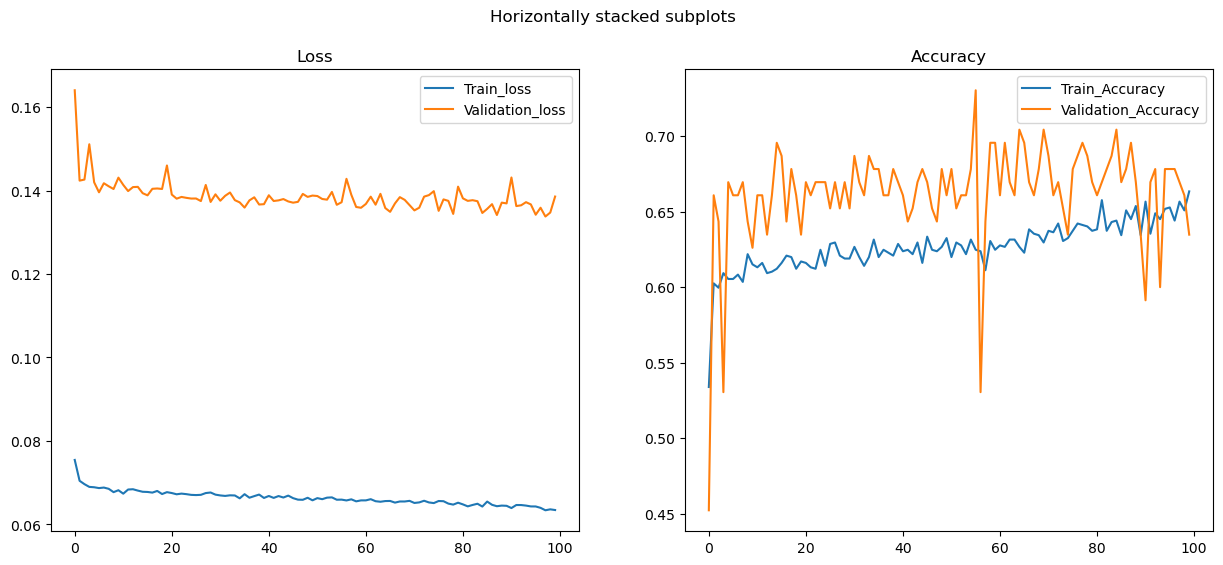

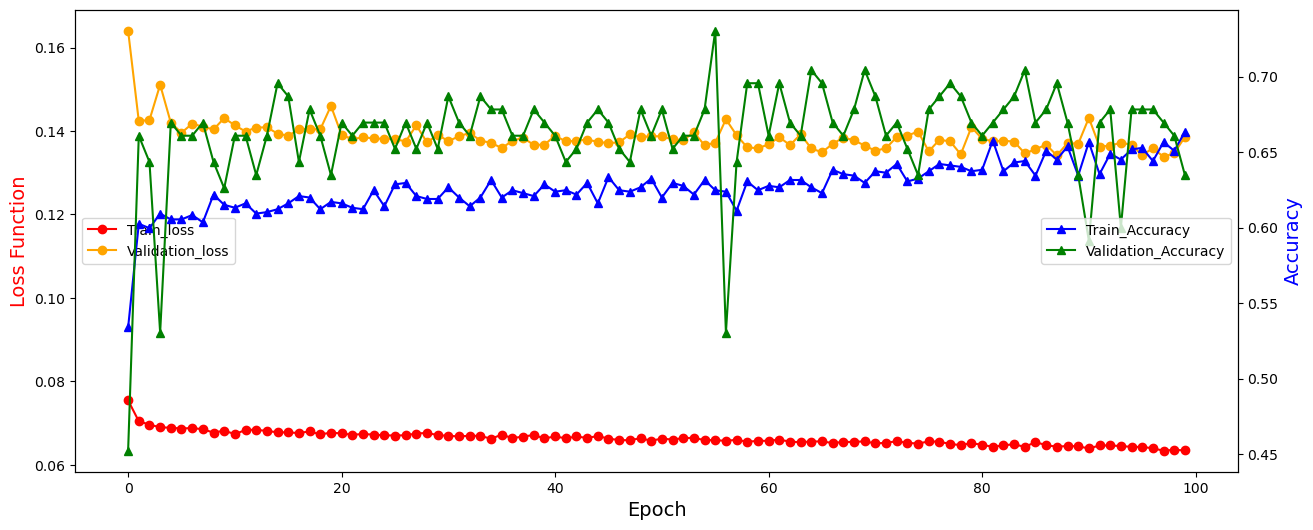

Current time: 39.485 minutes. Time expected till completion: 157.940 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:01<00:00, 13.81it/s]


train loss:  0.06340510927039834
Val loss:  0.13703440738760908
train accuracy:  0.648936170212766
Val accuracy:  0.6521739130434783
Current time: 39.880 minutes. Time expected till completion: 157.547 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.0636314528938419
Val loss:  0.1387917223184005
train accuracy:  0.6441005802707931
Val accuracy:  0.6869565217391305
Current time: 40.270 minutes. Time expected till completion: 157.131 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.06345864467510172
Val loss:  0.13766344526539678
train accuracy:  0.6615087040618955
Val accuracy:  0.6434782608695652
Current time: 40.666 minutes. Time expected till completion: 156.743 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.06406159379034947
Val loss:  0.13545878866444463
train accuracy:  0.6547388781431335
Val accuracy:  0.6434782608695652
Current time: 41.057 minutes. Time expected till completion: 156.331 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.06395277824807674
Val loss:  0.13490864245787912
train accuracy:  0.6460348162475822
Val accuracy:  0.6521739130434783
Current time: 41.450 minutes. Time expected till completion: 155.930 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.06423315699833736
Val loss:  0.13535782202430394
train accuracy:  0.6518375241779497
Val accuracy:  0.6695652173913044
Current time: 41.841 minutes. Time expected till completion: 155.522 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.06404196685702473
Val loss:  0.1402909719425699
train accuracy:  0.6673114119922631
Val accuracy:  0.6608695652173913
Current time: 42.234 minutes. Time expected till completion: 155.121 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.06385196269826686
Val loss:  0.13289458129716955
train accuracy:  0.6595744680851063
Val accuracy:  0.6869565217391305
Current time: 42.624 minutes. Time expected till completion: 154.708 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.06338841357129685
Val loss:  0.13785079976786738
train accuracy:  0.6731141199226306
Val accuracy:  0.6782608695652174
Current time: 43.017 minutes. Time expected till completion: 154.308 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.06375913267209406
Val loss:  0.13362918003745702
train accuracy:  0.6595744680851063
Val accuracy:  0.6869565217391305
Current time: 43.426 minutes. Time expected till completion: 153.965 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:01<00:00, 13.04it/s]


train loss:  0.06323635618506825
Val loss:  0.1370513299237127
train accuracy:  0.655705996131528
Val accuracy:  0.6608695652173913
Current time: 43.826 minutes. Time expected till completion: 153.588 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.06355828185146044
Val loss:  0.13571976008622544
train accuracy:  0.6673114119922631
Val accuracy:  0.6347826086956522
Current time: 44.220 minutes. Time expected till completion: 153.192 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:01<00:00, 13.26it/s]


train loss:  0.06329361647655701
Val loss:  0.13360303381214972
train accuracy:  0.6760154738878144
Val accuracy:  0.6608695652173913
Current time: 44.614 minutes. Time expected till completion: 152.793 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.06337476295474881
Val loss:  0.13279075207917587
train accuracy:  0.6595744680851063
Val accuracy:  0.6608695652173913
Current time: 45.007 minutes. Time expected till completion: 152.393 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.06343004545575184
Val loss:  0.13544930012329764
train accuracy:  0.6547388781431335
Val accuracy:  0.6086956521739131
Current time: 45.400 minutes. Time expected till completion: 151.993 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.0634573594859767
Val loss:  0.135527125130529
train accuracy:  0.6711798839458414
Val accuracy:  0.6695652173913044
Current time: 45.791 minutes. Time expected till completion: 151.583 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:01<00:00, 13.49it/s]


train loss:  0.06293985639596124
Val loss:  0.13865173692288607
train accuracy:  0.6827852998065764
Val accuracy:  0.6782608695652174
Current time: 46.182 minutes. Time expected till completion: 151.178 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.06353586214653989
Val loss:  0.1345725717751876
train accuracy:  0.6808510638297872
Val accuracy:  0.6521739130434783
Current time: 46.573 minutes. Time expected till completion: 150.771 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.06260572428629523
Val loss:  0.13594854966453884
train accuracy:  0.6711798839458414
Val accuracy:  0.6434782608695652
Current time: 46.965 minutes. Time expected till completion: 150.366 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.06323976241181851
Val loss:  0.13414322448813398
train accuracy:  0.6634429400386848
Val accuracy:  0.6695652173913044
Current time: 47.359 minutes. Time expected till completion: 149.972 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.06257808012473515
Val loss:  0.1367186048756475
train accuracy:  0.6808510638297872
Val accuracy:  0.6521739130434783
Current time: 47.751 minutes. Time expected till completion: 149.567 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.06290046827474922
Val loss:  0.13549405543700507
train accuracy:  0.6924564796905223
Val accuracy:  0.6869565217391305
Current time: 48.142 minutes. Time expected till completion: 149.160 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.06263952075397484
Val loss:  0.13315846194391665
train accuracy:  0.6769825918762089
Val accuracy:  0.6521739130434783
Current time: 48.538 minutes. Time expected till completion: 148.771 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.06267280718113513
Val loss:  0.13831897403882898
train accuracy:  0.6992263056092843
Val accuracy:  0.6521739130434783
Current time: 48.930 minutes. Time expected till completion: 148.367 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.06271000543692126
Val loss:  0.13653250207071718
train accuracy:  0.6818181818181818
Val accuracy:  0.6521739130434783
Current time: 49.320 minutes. Time expected till completion: 147.961 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.06272932443212956
Val loss:  0.13520438256471054
train accuracy:  0.6808510638297872
Val accuracy:  0.6608695652173913
Current time: 49.712 minutes. Time expected till completion: 147.559 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06240830280794627
Val loss:  0.1329910221307174
train accuracy:  0.6934235976789168
Val accuracy:  0.6869565217391305
Current time: 50.105 minutes. Time expected till completion: 147.158 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.06286978813850211
Val loss:  0.13362521814263384
train accuracy:  0.688588007736944
Val accuracy:  0.6608695652173913
Current time: 50.501 minutes. Time expected till completion: 146.770 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.06289673347307127
Val loss:  0.137601085331129
train accuracy:  0.6760154738878144
Val accuracy:  0.7043478260869566
Current time: 50.891 minutes. Time expected till completion: 146.360 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.06300872702663134
Val loss:  0.13323861775190934
train accuracy:  0.6740812379110251
Val accuracy:  0.6869565217391305
Current time: 51.282 minutes. Time expected till completion: 145.957 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:01<00:00, 13.73it/s]


train loss:  0.06206746477222996
Val loss:  0.1376030066738958
train accuracy:  0.7127659574468085
Val accuracy:  0.6260869565217392
Current time: 51.673 minutes. Time expected till completion: 145.553 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.0626407327919449
Val loss:  0.13232392901959628
train accuracy:  0.7050290135396519
Val accuracy:  0.6695652173913044
Current time: 52.065 minutes. Time expected till completion: 145.151 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.06244247171818864
Val loss:  0.14187011615089748
train accuracy:  0.7117988394584139
Val accuracy:  0.5478260869565217
Current time: 52.456 minutes. Time expected till completion: 144.748 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


train loss:  0.062407856464847145
Val loss:  0.13369368366573167
train accuracy:  0.7011605415860735
Val accuracy:  0.6782608695652174
Current time: 52.847 minutes. Time expected till completion: 144.344 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.062345597799326975
Val loss:  0.1329382061958313
train accuracy:  0.706963249516441
Val accuracy:  0.6695652173913044
Current time: 53.240 minutes. Time expected till completion: 143.945 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


train loss:  0.06187292760529878
Val loss:  0.13496745824813844
train accuracy:  0.723404255319149
Val accuracy:  0.6695652173913044
Current time: 53.630 minutes. Time expected till completion: 143.540 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.062281811145103644
Val loss:  0.13246745493101036
train accuracy:  0.7098646034816247
Val accuracy:  0.6695652173913044
Current time: 54.023 minutes. Time expected till completion: 143.141 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.06250594040411353
Val loss:  0.13492835552796073
train accuracy:  0.7011605415860735
Val accuracy:  0.6782608695652174
Current time: 54.416 minutes. Time expected till completion: 142.744 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.06281540374230139
Val loss:  0.1370434372321419
train accuracy:  0.6827852998065764
Val accuracy:  0.6782608695652174
Current time: 54.807 minutes. Time expected till completion: 142.341 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.06234301520039542
Val loss:  0.1339417011841484
train accuracy:  0.690522243713733
Val accuracy:  0.6782608695652174
Current time: 55.198 minutes. Time expected till completion: 141.938 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.06196655872020316
Val loss:  0.1350432883138242
train accuracy:  0.7224371373307543
Val accuracy:  0.6695652173913044
Current time: 55.592 minutes. Time expected till completion: 141.543 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.06176505121087198
Val loss:  0.13549972046976505
train accuracy:  0.7253384912959381
Val accuracy:  0.6782608695652174
Current time: 55.987 minutes. Time expected till completion: 141.150 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.061503366010562596
Val loss:  0.134764638154403
train accuracy:  0.730174081237911
Val accuracy:  0.6869565217391305
Current time: 56.381 minutes. Time expected till completion: 140.755 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:01<00:00, 13.36it/s]


train loss:  0.06152180799893761
Val loss:  0.1350800353547801
train accuracy:  0.7263056092843327
Val accuracy:  0.6956521739130435
Current time: 56.772 minutes. Time expected till completion: 140.353 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.06181998951522709
Val loss:  0.13294472383416217
train accuracy:  0.7137330754352031
Val accuracy:  0.6869565217391305
Current time: 57.173 minutes. Time expected till completion: 139.976 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.06091183124243406
Val loss:  0.13333517002022785
train accuracy:  0.7398452611218569
Val accuracy:  0.6782608695652174
Current time: 57.565 minutes. Time expected till completion: 139.575 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.06121406800742306
Val loss:  0.14993355688841448
train accuracy:  0.7330754352030948
Val accuracy:  0.5739130434782609
Current time: 57.962 minutes. Time expected till completion: 139.188 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.06161102796661554
Val loss:  0.13334528518759686
train accuracy:  0.7292069632495164
Val accuracy:  0.6956521739130435
Current time: 58.354 minutes. Time expected till completion: 138.787 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


train loss:  0.06101778478179725
Val loss:  0.1399385120557702
train accuracy:  0.753384912959381
Val accuracy:  0.6086956521739131
Current time: 58.756 minutes. Time expected till completion: 138.412 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.06068780793442717
Val loss:  0.13332342686860457
train accuracy:  0.741779497098646
Val accuracy:  0.6608695652173913
Current time: 59.147 minutes. Time expected till completion: 138.010 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:01<00:00, 13.42it/s]


train loss:  0.06055708964512012
Val loss:  0.13844924232234126
train accuracy:  0.741779497098646
Val accuracy:  0.7217391304347827
Current time: 59.543 minutes. Time expected till completion: 137.620 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:01<00:00, 13.35it/s]


train loss:  0.06128860995663434
Val loss:  0.13137953540553218
train accuracy:  0.7408123791102514
Val accuracy:  0.6869565217391305
Current time: 59.935 minutes. Time expected till completion: 137.220 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.06080025296146681
Val loss:  0.13677942597347756
train accuracy:  0.7379110251450677
Val accuracy:  0.6173913043478261
Current time: 60.331 minutes. Time expected till completion: 136.829 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.06110762967592973
Val loss:  0.13414722162744272
train accuracy:  0.7504835589941973
Val accuracy:  0.6782608695652174
Current time: 60.728 minutes. Time expected till completion: 136.440 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]


train loss:  0.06123555611595655
Val loss:  0.13343534573264745
train accuracy:  0.741779497098646
Val accuracy:  0.6347826086956522
Current time: 61.120 minutes. Time expected till completion: 136.041 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.06068728111929313
Val loss:  0.13802219421967216
train accuracy:  0.7408123791102514
Val accuracy:  0.6434782608695652
Current time: 61.511 minutes. Time expected till completion: 135.640 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


train loss:  0.061129323230260116
Val loss:  0.14298577153164407
train accuracy:  0.7359767891682786
Val accuracy:  0.6
Current time: 61.902 minutes. Time expected till completion: 135.239 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:01<00:00, 13.86it/s]


train loss:  0.06101809375751872
Val loss:  0.13211617884428606
train accuracy:  0.7350096711798839
Val accuracy:  0.6869565217391305
Current time: 62.296 minutes. Time expected till completion: 134.843 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.06107331584685084
Val loss:  0.13282893792442654
train accuracy:  0.741779497098646
Val accuracy:  0.6608695652173913
Current time: 62.686 minutes. Time expected till completion: 134.441 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:01<00:00, 13.54it/s]


train loss:  0.06063344405974825
Val loss:  0.13472603093022886
train accuracy:  0.741779497098646
Val accuracy:  0.6695652173913044
Current time: 63.079 minutes. Time expected till completion: 134.042 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.06024246185845056
Val loss:  0.14309518440910007
train accuracy:  0.758220502901354
Val accuracy:  0.5217391304347826
Current time: 63.473 minutes. Time expected till completion: 133.649 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.06059314480602626
Val loss:  0.1363836557968803
train accuracy:  0.7446808510638298
Val accuracy:  0.6347826086956522
Current time: 63.883 minutes. Time expected till completion: 133.287 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:01<00:00, 13.75it/s]


train loss:  0.06020933026501934
Val loss:  0.13279976585636968
train accuracy:  0.753384912959381
Val accuracy:  0.6782608695652174
Current time: 64.276 minutes. Time expected till completion: 132.890 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:01<00:00, 13.12it/s]


train loss:  0.06033720661178087
Val loss:  0.14248929386553558
train accuracy:  0.7495164410058027
Val accuracy:  0.5739130434782609
Current time: 64.677 minutes. Time expected till completion: 132.509 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:01<00:00, 12.75it/s]


train loss:  0.060324940563862284
Val loss:  0.13457715977793155
train accuracy:  0.7611218568665378
Val accuracy:  0.6608695652173913
Current time: 65.087 minutes. Time expected till completion: 132.147 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.06021605290803965
Val loss:  0.13430712378543355
train accuracy:  0.7640232108317214
Val accuracy:  0.7130434782608696
Current time: 65.501 minutes. Time expected till completion: 131.791 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:01<00:00, 13.08it/s]


train loss:  0.05983934705677069
Val loss:  0.1445495792057203
train accuracy:  0.7601547388781431
Val accuracy:  0.5565217391304348
Current time: 65.916 minutes. Time expected till completion: 131.437 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.05968246590238014
Val loss:  0.13522683485694553
train accuracy:  0.7804642166344294
Val accuracy:  0.6695652173913044
Current time: 66.327 minutes. Time expected till completion: 131.075 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:01<00:00, 13.35it/s]


train loss:  0.05970959696825053
Val loss:  0.13653420417205148
train accuracy:  0.7601547388781431
Val accuracy:  0.6347826086956522
Current time: 66.731 minutes. Time expected till completion: 130.698 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


train loss:  0.059508618464552916
Val loss:  0.13463859350784965
train accuracy:  0.7746615087040619
Val accuracy:  0.7043478260869566
Current time: 67.128 minutes. Time expected till completion: 130.308 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:01<00:00, 13.43it/s]


train loss:  0.059984365099864496
Val loss:  0.13744913339614867
train accuracy:  0.7640232108317214
Val accuracy:  0.6782608695652174
Current time: 67.541 minutes. Time expected till completion: 129.947 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:01<00:00, 13.49it/s]


train loss:  0.059023621638001046
Val loss:  0.14176995235940684
train accuracy:  0.7794970986460348
Val accuracy:  0.5826086956521739
Current time: 67.943 minutes. Time expected till completion: 129.565 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


train loss:  0.05974995715244596
Val loss:  0.13259498295576677
train accuracy:  0.769825918762089
Val accuracy:  0.6869565217391305
Current time: 68.350 minutes. Time expected till completion: 129.193 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:01<00:00, 13.42it/s]


train loss:  0.06020168547934674
Val loss:  0.13332149464151133
train accuracy:  0.7553191489361702
Val accuracy:  0.7130434782608696
Current time: 68.757 minutes. Time expected till completion: 128.820 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:01<00:00, 13.75it/s]


train loss:  0.059280853898658975
Val loss:  0.13805964044902636
train accuracy:  0.7736943907156673
Val accuracy:  0.6173913043478261
Current time: 69.169 minutes. Time expected till completion: 128.457 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:01<00:00, 13.40it/s]


train loss:  0.060190958026760555
Val loss:  0.1337656767471977
train accuracy:  0.7475822050290135
Val accuracy:  0.6608695652173913
Current time: 69.590 minutes. Time expected till completion: 128.108 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.059391270350210905
Val loss:  0.13503584447114364
train accuracy:  0.7669245647969052
Val accuracy:  0.6956521739130435
Current time: 70.004 minutes. Time expected till completion: 127.748 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.05844743258717904
Val loss:  0.1330737777378248
train accuracy:  0.7940038684719536
Val accuracy:  0.7043478260869566
Current time: 70.402 minutes. Time expected till completion: 127.356 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:01<00:00, 12.94it/s]


train loss:  0.05965488169133317
Val loss:  0.1402664505917093
train accuracy:  0.776595744680851
Val accuracy:  0.6260869565217392
Current time: 70.810 minutes. Time expected till completion: 126.983 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


train loss:  0.05876134402286153
Val loss:  0.13413686130357824
train accuracy:  0.7756286266924565
Val accuracy:  0.6608695652173913
Current time: 71.235 minutes. Time expected till completion: 126.640 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.059037803565971624
Val loss:  0.140347697423852
train accuracy:  0.7785299806576402
Val accuracy:  0.6173913043478261
Current time: 71.632 minutes. Time expected till completion: 126.247 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.05890415484946747
Val loss:  0.134357590260713
train accuracy:  0.7775628626692457
Val accuracy:  0.6434782608695652
Current time: 72.033 minutes. Time expected till completion: 125.859 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.05855661549927879
Val loss:  0.13293715663578198
train accuracy:  0.7901353965183753
Val accuracy:  0.6782608695652174
Current time: 72.429 minutes. Time expected till completion: 125.464 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.05871020110478945
Val loss:  0.1403954987940581
train accuracy:  0.7920696324951644
Val accuracy:  0.6521739130434783
Current time: 72.825 minutes. Time expected till completion: 125.069 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.05944394702145855
Val loss:  0.13442506634670756
train accuracy:  0.7707930367504836
Val accuracy:  0.6956521739130435
Current time: 73.220 minutes. Time expected till completion: 124.671 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


train loss:  0.05915533775748321
Val loss:  0.12984293129133143
train accuracy:  0.7804642166344294
Val accuracy:  0.7739130434782608
Current time: 73.611 minutes. Time expected till completion: 124.267 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.058819652929527386
Val loss:  0.13380933533544126
train accuracy:  0.7727272727272727
Val accuracy:  0.6782608695652174
Current time: 74.004 minutes. Time expected till completion: 123.868 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.05718992659155589
Val loss:  0.13393671460773635
train accuracy:  0.8065764023210832
Val accuracy:  0.7043478260869566
Current time: 74.398 minutes. Time expected till completion: 123.470 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.05833507333548894
Val loss:  0.13510561922322148
train accuracy:  0.7998065764023211
Val accuracy:  0.6608695652173913
Current time: 74.794 minutes. Time expected till completion: 123.074 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.05864810395978636
Val loss:  0.13507814925649891
train accuracy:  0.781431334622824
Val accuracy:  0.7043478260869566
Current time: 75.186 minutes. Time expected till completion: 122.673 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


train loss:  0.058297356565409054
Val loss:  0.13218907895295517
train accuracy:  0.7911025145067698
Val accuracy:  0.7391304347826086
Current time: 75.581 minutes. Time expected till completion: 122.275 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.057817506086895495
Val loss:  0.13954554640728495
train accuracy:  0.7969052224371374
Val accuracy:  0.6173913043478261
Current time: 75.972 minutes. Time expected till completion: 121.872 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:01<00:00, 13.71it/s]


train loss:  0.058907258268481755
Val loss:  0.1390327635018722
train accuracy:  0.7833655705996132
Val accuracy:  0.6260869565217392
Current time: 76.368 minutes. Time expected till completion: 121.477 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.05922916981191654
Val loss:  0.1376440535420957
train accuracy:  0.7794970986460348
Val accuracy:  0.6695652173913044
Current time: 76.768 minutes. Time expected till completion: 121.088 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.059302855160526885
Val loss:  0.13234217840692272
train accuracy:  0.7756286266924565
Val accuracy:  0.7217391304347827
Current time: 77.159 minutes. Time expected till completion: 120.685 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:01<00:00, 13.87it/s]


train loss:  0.058155111982928484
Val loss:  0.1375620945640232
train accuracy:  0.8075435203094777
Val accuracy:  0.6434782608695652
Current time: 77.553 minutes. Time expected till completion: 120.287 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.058325098665355485
Val loss:  0.13842999209528384
train accuracy:  0.7959381044487428
Val accuracy:  0.5826086956521739
Current time: 77.966 minutes. Time expected till completion: 119.917 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


train loss:  0.05816850844388774
Val loss:  0.13908980981163357
train accuracy:  0.8036750483558994
Val accuracy:  0.6434782608695652
Current time: 78.368 minutes. Time expected till completion: 119.532 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.05852906956432866
Val loss:  0.1294769048690796
train accuracy:  0.7901353965183753
Val accuracy:  0.7130434782608696
Current time: 78.765 minutes. Time expected till completion: 119.137 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


train loss:  0.057565856026035214
Val loss:  0.13590265460636305
train accuracy:  0.809477756286267
Val accuracy:  0.6521739130434783
Saving model checkpoint


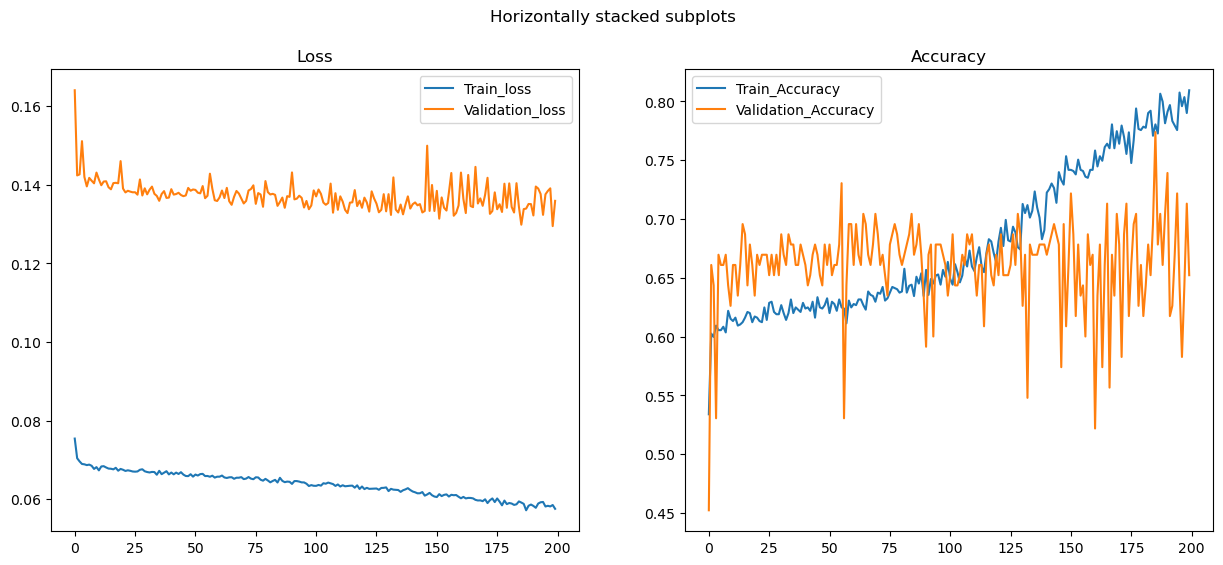

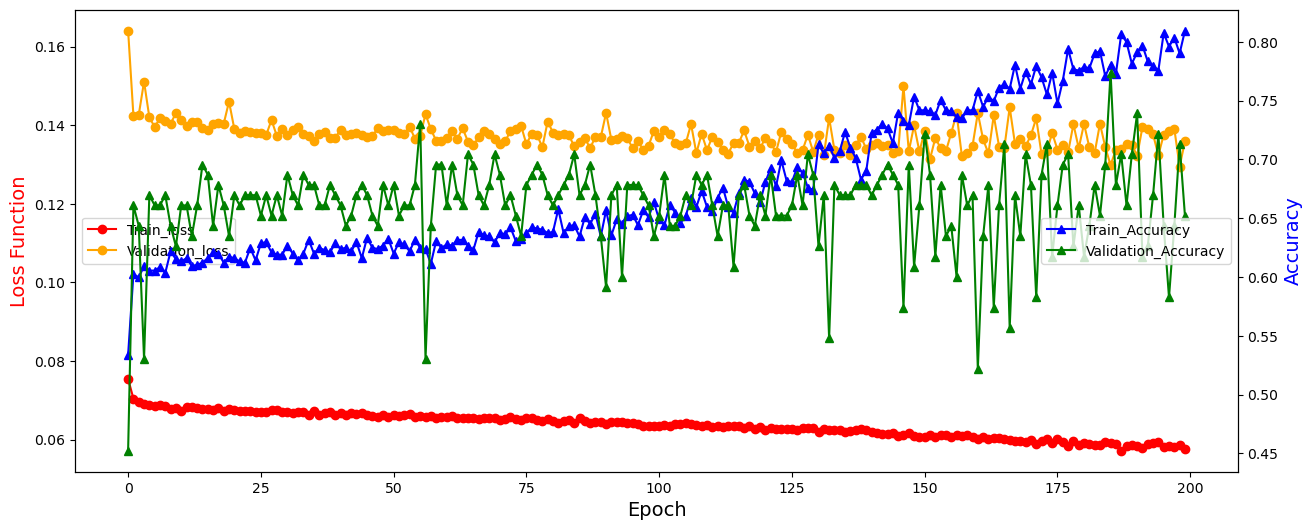

Current time: 79.179 minutes. Time expected till completion: 118.768 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.057748572450541893
Val loss:  0.13224412306495334
train accuracy:  0.8085106382978723
Val accuracy:  0.7130434782608696
Current time: 79.577 minutes. Time expected till completion: 118.376 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.05710676842778056
Val loss:  0.13402837048406185
train accuracy:  0.8201160541586073
Val accuracy:  0.6782608695652174
Current time: 79.966 minutes. Time expected till completion: 117.970 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.058733603191099035
Val loss:  0.13227625307829483
train accuracy:  0.7911025145067698
Val accuracy:  0.6782608695652174
Current time: 80.358 minutes. Time expected till completion: 117.569 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:01<00:00, 13.75it/s]


train loss:  0.05770836266143179
Val loss:  0.13274258893469107
train accuracy:  0.8007736943907157
Val accuracy:  0.7043478260869566
Current time: 80.750 minutes. Time expected till completion: 117.166 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:01<00:00, 13.43it/s]


train loss:  0.057415867393667046
Val loss:  0.13637086723161781
train accuracy:  0.8104448742746615
Val accuracy:  0.6347826086956522
Current time: 81.145 minutes. Time expected till completion: 116.769 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:01<00:00, 12.18it/s]


train loss:  0.057345556970721745
Val loss:  0.13311453746712726
train accuracy:  0.8056092843326886
Val accuracy:  0.6956521739130435
Current time: 81.551 minutes. Time expected till completion: 116.388 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.057602898295197776
Val loss:  0.14632666629293692
train accuracy:  0.8065764023210832
Val accuracy:  0.5391304347826087
Current time: 81.967 minutes. Time expected till completion: 116.021 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.05813814218316364
Val loss:  0.13178167654120404
train accuracy:  0.7959381044487428
Val accuracy:  0.6956521739130435
Current time: 82.359 minutes. Time expected till completion: 115.619 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:01<00:00, 13.29it/s]


train loss:  0.05760638044004975
Val loss:  0.1334005215893621
train accuracy:  0.7998065764023211
Val accuracy:  0.7043478260869566
Current time: 82.752 minutes. Time expected till completion: 115.219 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.057390849468094696
Val loss:  0.13450486867324166
train accuracy:  0.8133462282398453
Val accuracy:  0.6956521739130435
Current time: 83.146 minutes. Time expected till completion: 114.821 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.057783998419283895
Val loss:  0.1488186820693638
train accuracy:  0.8065764023210832
Val accuracy:  0.5826086956521739
Current time: 83.543 minutes. Time expected till completion: 114.426 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.05865472589747357
Val loss:  0.13269308442654817
train accuracy:  0.7843326885880078
Val accuracy:  0.6956521739130435
Current time: 83.937 minutes. Time expected till completion: 114.027 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.05892764317228439
Val loss:  0.14110820397086765
train accuracy:  0.7785299806576402
Val accuracy:  0.6
Current time: 84.330 minutes. Time expected till completion: 113.628 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:01<00:00, 13.75it/s]


train loss:  0.05769471596472499
Val loss:  0.14283001474712206
train accuracy:  0.8104448742746615
Val accuracy:  0.5478260869565217
Current time: 84.722 minutes. Time expected till completion: 113.226 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  0.0570768022214421
Val loss:  0.14356710444325987
train accuracy:  0.8239845261121856
Val accuracy:  0.6
Current time: 85.120 minutes. Time expected till completion: 112.834 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.05764663582613667
Val loss:  0.13680890954059102
train accuracy:  0.8104448742746615
Val accuracy:  0.6695652173913044
Current time: 85.521 minutes. Time expected till completion: 112.444 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.0557183268222403
Val loss:  0.12880975008010864
train accuracy:  0.839458413926499
Val accuracy:  0.7304347826086957
Current time: 85.910 minutes. Time expected till completion: 112.039 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.057037323886236786
Val loss:  0.13602714331253715
train accuracy:  0.8249516441005803
Val accuracy:  0.7043478260869566
Current time: 86.310 minutes. Time expected till completion: 111.648 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.057199323488619155
Val loss:  0.13145605429359106
train accuracy:  0.8123791102514507
Val accuracy:  0.7391304347826086
Current time: 86.705 minutes. Time expected till completion: 111.251 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.05704246008880364
Val loss:  0.13118794534517372
train accuracy:  0.8152804642166345
Val accuracy:  0.7217391304347827
Current time: 87.097 minutes. Time expected till completion: 110.851 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.05740385953646795
Val loss:  0.1359960219134455
train accuracy:  0.811411992263056
Val accuracy:  0.7043478260869566
Current time: 87.493 minutes. Time expected till completion: 110.455 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.05707528380176315
Val loss:  0.13670093443082726
train accuracy:  0.8123791102514507
Val accuracy:  0.6434782608695652
Current time: 87.888 minutes. Time expected till completion: 110.058 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.05685121962364684
Val loss:  0.13481135005536288
train accuracy:  0.8259187620889749
Val accuracy:  0.6695652173913044
Current time: 88.278 minutes. Time expected till completion: 109.655 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.056804178704145565
Val loss:  0.13820508873980977
train accuracy:  0.8230174081237911
Val accuracy:  0.6608695652173913
Current time: 88.673 minutes. Time expected till completion: 109.258 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.05738214661351025
Val loss:  0.13015851611676424
train accuracy:  0.8036750483558994
Val accuracy:  0.6956521739130435
Current time: 89.063 minutes. Time expected till completion: 108.855 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.05588209242839186
Val loss:  0.13048324636791064
train accuracy:  0.839458413926499
Val accuracy:  0.7391304347826086
Current time: 89.459 minutes. Time expected till completion: 108.459 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:01<00:00, 13.84it/s]


train loss:  0.056720654842240203
Val loss:  0.14212408635927284
train accuracy:  0.8249516441005803
Val accuracy:  0.6086956521739131
Current time: 89.855 minutes. Time expected till completion: 108.063 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:01<00:00, 13.19it/s]


train loss:  0.05648500534275284
Val loss:  0.13980397452478824
train accuracy:  0.8307543520309478
Val accuracy:  0.6260869565217392
Current time: 90.257 minutes. Time expected till completion: 107.675 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.0569096423786429
Val loss:  0.14580440469410108
train accuracy:  0.8056092843326886
Val accuracy:  0.591304347826087
Current time: 90.652 minutes. Time expected till completion: 107.278 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:01<00:00, 13.87it/s]


train loss:  0.057269559376936126
Val loss:  0.13536442984705385
train accuracy:  0.8191489361702128
Val accuracy:  0.6869565217391305
Current time: 91.043 minutes. Time expected till completion: 106.876 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.05624768570267255
Val loss:  0.13359053186748338
train accuracy:  0.8336557059961315
Val accuracy:  0.7043478260869566
Current time: 91.435 minutes. Time expected till completion: 106.476 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:01<00:00, 13.49it/s]


train loss:  0.056299523700828476
Val loss:  0.1297189525935961
train accuracy:  0.8326885880077369
Val accuracy:  0.7391304347826086
Current time: 91.845 minutes. Time expected till completion: 106.096 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:01<00:00, 13.85it/s]


train loss:  0.05641470731342323
Val loss:  0.1352112775263579
train accuracy:  0.8336557059961315
Val accuracy:  0.6521739130434783
Current time: 92.236 minutes. Time expected till completion: 105.695 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.055811048015173906
Val loss:  0.14567772927491562
train accuracy:  0.8539651837524178
Val accuracy:  0.6086956521739131
Current time: 92.628 minutes. Time expected till completion: 105.295 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.056795489626650195
Val loss:  0.13366640080576359
train accuracy:  0.8133462282398453
Val accuracy:  0.6869565217391305
Current time: 93.022 minutes. Time expected till completion: 104.897 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.05695851547805668
Val loss:  0.1326521220414535
train accuracy:  0.8220502901353965
Val accuracy:  0.7043478260869566
Current time: 93.424 minutes. Time expected till completion: 104.508 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:01<00:00, 12.98it/s]


train loss:  0.05570754760469182
Val loss:  0.13339118439218273
train accuracy:  0.8452611218568665
Val accuracy:  0.7043478260869566
Current time: 93.825 minutes. Time expected till completion: 104.118 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.055757936241548345
Val loss:  0.13423991825269616
train accuracy:  0.8423597678916828
Val accuracy:  0.6608695652173913
Current time: 94.216 minutes. Time expected till completion: 103.717 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.05660001878812189
Val loss:  0.1330013358074686
train accuracy:  0.8259187620889749
Val accuracy:  0.6869565217391305
Current time: 94.607 minutes. Time expected till completion: 103.315 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.05560339990160221
Val loss:  0.13806589893672777
train accuracy:  0.8423597678916828
Val accuracy:  0.6521739130434783
Current time: 95.003 minutes. Time expected till completion: 102.920 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.054942645406354094
Val loss:  0.14187623055084891
train accuracy:  0.8539651837524178
Val accuracy:  0.5739130434782609
Current time: 95.404 minutes. Time expected till completion: 102.530 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.05623895996313261
Val loss:  0.1403839225354402
train accuracy:  0.8336557059961315
Val accuracy:  0.6347826086956522
Current time: 95.807 minutes. Time expected till completion: 102.142 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.056303022620295184
Val loss:  0.13463016696598218
train accuracy:  0.8259187620889749
Val accuracy:  0.6695652173913044
Current time: 96.203 minutes. Time expected till completion: 101.745 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:01<00:00, 13.29it/s]


train loss:  0.055474797346605785
Val loss:  0.13189982434977657
train accuracy:  0.8578336557059961
Val accuracy:  0.7043478260869566
Current time: 96.600 minutes. Time expected till completion: 101.351 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.054761198722186356
Val loss:  0.13364677584689597
train accuracy:  0.8588007736943907
Val accuracy:  0.7130434782608696
Current time: 97.001 minutes. Time expected till completion: 100.960 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:01<00:00, 13.26it/s]


train loss:  0.05512384473701049
Val loss:  0.13405494638111282
train accuracy:  0.8597678916827853
Val accuracy:  0.6869565217391305
Current time: 97.397 minutes. Time expected till completion: 100.565 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.056014939940874996
Val loss:  0.14176031040108722
train accuracy:  0.8384912959381045
Val accuracy:  0.6
Current time: 97.789 minutes. Time expected till completion: 100.164 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.0558469412520499
Val loss:  0.13431636095046998
train accuracy:  0.839458413926499
Val accuracy:  0.6782608695652174
Current time: 98.186 minutes. Time expected till completion: 99.770 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.055273648099235226
Val loss:  0.1306533429933631
train accuracy:  0.8433268858800773
Val accuracy:  0.7043478260869566
Current time: 98.582 minutes. Time expected till completion: 99.373 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:01<00:00, 13.42it/s]


train loss:  0.055244856519440846
Val loss:  0.14025501997574516
train accuracy:  0.851063829787234
Val accuracy:  0.6173913043478261
Current time: 98.976 minutes. Time expected till completion: 98.976 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:01<00:00, 13.40it/s]


train loss:  0.05506116728256934
Val loss:  0.1406588087911191
train accuracy:  0.8617021276595744
Val accuracy:  0.591304347826087
Current time: 99.376 minutes. Time expected till completion: 98.584 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


train loss:  0.05543158397914363
Val loss:  0.1364564361779586
train accuracy:  0.8578336557059961
Val accuracy:  0.6695652173913044
Current time: 99.776 minutes. Time expected till completion: 98.192 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.05506983041993885
Val loss:  0.13233442980310192
train accuracy:  0.844294003868472
Val accuracy:  0.6869565217391305
Current time: 100.182 minutes. Time expected till completion: 97.806 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.05434909952908927
Val loss:  0.13467878621557486
train accuracy:  0.8733075435203095
Val accuracy:  0.7043478260869566
Current time: 100.573 minutes. Time expected till completion: 97.405 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.05524602855197235
Val loss:  0.13354871273040772
train accuracy:  0.844294003868472
Val accuracy:  0.6782608695652174
Current time: 100.991 minutes. Time expected till completion: 97.031 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.055646184565250834
Val loss:  0.1356915499853051
train accuracy:  0.8404255319148937
Val accuracy:  0.7043478260869566
Current time: 101.385 minutes. Time expected till completion: 96.632 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.0548838163713422
Val loss:  0.13603029613909515
train accuracy:  0.8558994197292069
Val accuracy:  0.6434782608695652
Current time: 101.779 minutes. Time expected till completion: 96.235 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:01<00:00, 12.68it/s]


train loss:  0.05542052979626093
Val loss:  0.13085969323697297
train accuracy:  0.8529980657640233
Val accuracy:  0.7130434782608696
Current time: 102.176 minutes. Time expected till completion: 95.840 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.05498391355259967
Val loss:  0.13607517636340596
train accuracy:  0.8539651837524178
Val accuracy:  0.6434782608695652
Current time: 102.578 minutes. Time expected till completion: 95.449 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.055760134004301444
Val loss:  0.1361206837322401
train accuracy:  0.8433268858800773
Val accuracy:  0.6608695652173913
Current time: 102.978 minutes. Time expected till completion: 95.057 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.054936226435740636
Val loss:  0.14067500052244766
train accuracy:  0.8529980657640233
Val accuracy:  0.591304347826087
Current time: 103.380 minutes. Time expected till completion: 94.666 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.055323391864562636
Val loss:  0.14026638839555824
train accuracy:  0.851063829787234
Val accuracy:  0.6086956521739131
Current time: 103.775 minutes. Time expected till completion: 94.268 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.054798507540553404
Val loss:  0.13698496092920717
train accuracy:  0.8607350096711799
Val accuracy:  0.6782608695652174
Current time: 104.172 minutes. Time expected till completion: 93.873 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


train loss:  0.05572018246355555
Val loss:  0.13394273571346116
train accuracy:  0.8452611218568665
Val accuracy:  0.7217391304347827
Current time: 104.565 minutes. Time expected till completion: 93.475 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.05467740992512878
Val loss:  0.14582806048185928
train accuracy:  0.8597678916827853
Val accuracy:  0.5739130434782609
Current time: 104.960 minutes. Time expected till completion: 93.077 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.05498938957081542
Val loss:  0.14165154332699983
train accuracy:  0.8549323017408124
Val accuracy:  0.6
Current time: 105.364 minutes. Time expected till completion: 92.688 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]


train loss:  0.05538673344387077
Val loss:  0.13088115453720092
train accuracy:  0.8375241779497099
Val accuracy:  0.7304347826086957
Current time: 105.766 minutes. Time expected till completion: 92.298 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.05461501867674306
Val loss:  0.13386745660201363
train accuracy:  0.8588007736943907
Val accuracy:  0.6782608695652174
Current time: 106.168 minutes. Time expected till completion: 91.907 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.054757053547717156
Val loss:  0.13584356618964155
train accuracy:  0.8558994197292069
Val accuracy:  0.6956521739130435
Current time: 106.563 minutes. Time expected till completion: 91.509 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.0529912325123062
Val loss:  0.13706007833066194
train accuracy:  0.8887814313346228
Val accuracy:  0.6608695652173913
Current time: 106.956 minutes. Time expected till completion: 91.111 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.0538202534561231
Val loss:  0.14448817242746767
train accuracy:  0.8762088974854932
Val accuracy:  0.5826086956521739
Current time: 107.354 minutes. Time expected till completion: 90.716 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


train loss:  0.054854005978693124
Val loss:  0.1408873552861421
train accuracy:  0.8617021276595744
Val accuracy:  0.591304347826087
Current time: 107.749 minutes. Time expected till completion: 90.319 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.054027669376745906
Val loss:  0.13510463030441947
train accuracy:  0.8704061895551257
Val accuracy:  0.6521739130434783
Current time: 108.149 minutes. Time expected till completion: 89.926 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.054451369916447355
Val loss:  0.12916540270266325
train accuracy:  0.8558994197292069
Val accuracy:  0.7391304347826086
Current time: 108.544 minutes. Time expected till completion: 89.529 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:01<00:00, 13.89it/s]


train loss:  0.05492954685332927
Val loss:  0.13700385871140852
train accuracy:  0.8597678916827853
Val accuracy:  0.6695652173913044
Current time: 108.941 minutes. Time expected till completion: 89.133 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:01<00:00, 13.26it/s]


train loss:  0.05644853975141072
Val loss:  0.13270142285720163
train accuracy:  0.8278529980657641
Val accuracy:  0.6782608695652174
Current time: 109.338 minutes. Time expected till completion: 88.738 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:01<00:00, 12.76it/s]


train loss:  0.054521097666520905
Val loss:  0.14219467950903852
train accuracy:  0.8665377176015474
Val accuracy:  0.6347826086956522
Current time: 109.731 minutes. Time expected till completion: 88.339 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.05522725746986714
Val loss:  0.132532246734785
train accuracy:  0.8462282398452611
Val accuracy:  0.7043478260869566
Current time: 110.141 minutes. Time expected till completion: 87.954 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.05402810574730775
Val loss:  0.13618072323177172
train accuracy:  0.8752417794970987
Val accuracy:  0.6521739130434783
Current time: 110.533 minutes. Time expected till completion: 87.555 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.05318781497169509
Val loss:  0.13277517868124922
train accuracy:  0.8868471953578336
Val accuracy:  0.7043478260869566
Current time: 110.927 minutes. Time expected till completion: 87.157 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.05376911814715461
Val loss:  0.1388713986977287
train accuracy:  0.8810444874274661
Val accuracy:  0.6521739130434783
Current time: 111.324 minutes. Time expected till completion: 86.762 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.05408704032980958
Val loss:  0.130744309010713
train accuracy:  0.867504835589942
Val accuracy:  0.7130434782608696
Current time: 111.726 minutes. Time expected till completion: 86.369 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:01<00:00, 13.40it/s]


train loss:  0.05377000287838093
Val loss:  0.14593979690385903
train accuracy:  0.8762088974854932
Val accuracy:  0.6
Current time: 112.129 minutes. Time expected till completion: 85.978 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


train loss:  0.05365724812623841
Val loss:  0.13433863598367443
train accuracy:  0.8878143133462283
Val accuracy:  0.6869565217391305
Current time: 112.539 minutes. Time expected till completion: 85.593 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.055584553996645046
Val loss:  0.13043667492659194
train accuracy:  0.8539651837524178
Val accuracy:  0.7304347826086957
Current time: 112.942 minutes. Time expected till completion: 85.202 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


train loss:  0.05392520559133829
Val loss:  0.13338772939599078
train accuracy:  0.8762088974854932
Val accuracy:  0.7043478260869566
Current time: 113.335 minutes. Time expected till completion: 84.803 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.054358268153044884
Val loss:  0.13732088804244996
train accuracy:  0.8636363636363636
Val accuracy:  0.6347826086956522
Current time: 113.732 minutes. Time expected till completion: 84.408 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.0528965753789566
Val loss:  0.1331421136856079
train accuracy:  0.8965183752417795
Val accuracy:  0.7217391304347827
Current time: 114.135 minutes. Time expected till completion: 84.016 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.05360546356474177
Val loss:  0.13901989252670952
train accuracy:  0.8800773694390716
Val accuracy:  0.6608695652173913
Current time: 114.535 minutes. Time expected till completion: 83.622 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.05367970570374273
Val loss:  0.13125153624493144
train accuracy:  0.8800773694390716
Val accuracy:  0.7043478260869566
Current time: 114.928 minutes. Time expected till completion: 83.223 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.054183698426824016
Val loss:  0.13719547727833623
train accuracy:  0.8733075435203095
Val accuracy:  0.6608695652173913
Current time: 115.327 minutes. Time expected till completion: 82.829 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.05391229363428555
Val loss:  0.13180309119431868
train accuracy:  0.8704061895551257
Val accuracy:  0.7217391304347827
Current time: 115.720 minutes. Time expected till completion: 82.430 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.053072311719104905
Val loss:  0.1415722986926203
train accuracy:  0.8926499032882012
Val accuracy:  0.6173913043478261
Current time: 116.112 minutes. Time expected till completion: 82.031 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.05558489600279345
Val loss:  0.1321389447087827
train accuracy:  0.8462282398452611
Val accuracy:  0.7130434782608696
Current time: 116.511 minutes. Time expected till completion: 81.637 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.05466838512475993
Val loss:  0.13127428189567897
train accuracy:  0.8520309477756286
Val accuracy:  0.6782608695652174
Current time: 116.908 minutes. Time expected till completion: 81.241 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.0543786852226036
Val loss:  0.13326834803042203
train accuracy:  0.8655705996131529
Val accuracy:  0.6608695652173913
Current time: 117.302 minutes. Time expected till completion: 80.844 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


train loss:  0.05311695329225271
Val loss:  0.13262409282767254
train accuracy:  0.8936170212765957
Val accuracy:  0.7304347826086957
Current time: 117.699 minutes. Time expected till completion: 80.448 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.05280340196316201
Val loss:  0.13676497988078906
train accuracy:  0.9003868471953579
Val accuracy:  0.6695652173913044
Current time: 118.092 minutes. Time expected till completion: 80.049 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:01<00:00, 13.29it/s]


train loss:  0.053938572192330426
Val loss:  0.1369765888089719
train accuracy:  0.8762088974854932
Val accuracy:  0.6608695652173913
Current time: 118.487 minutes. Time expected till completion: 79.652 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.0542802098756602
Val loss:  0.137995299567347
train accuracy:  0.8733075435203095
Val accuracy:  0.6260869565217392
Saving model checkpoint


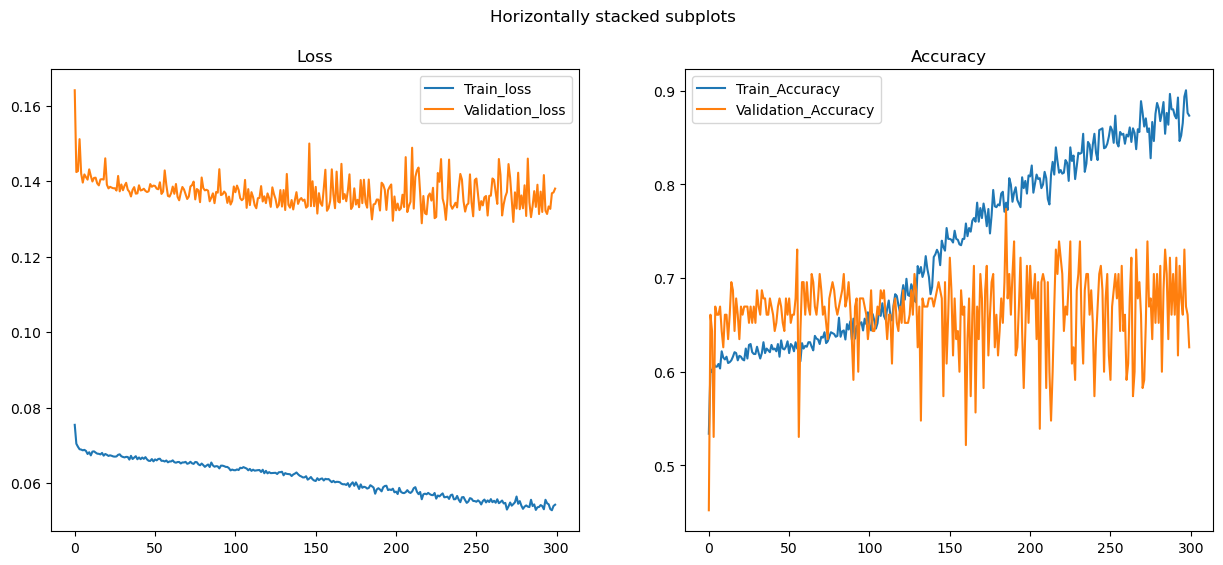

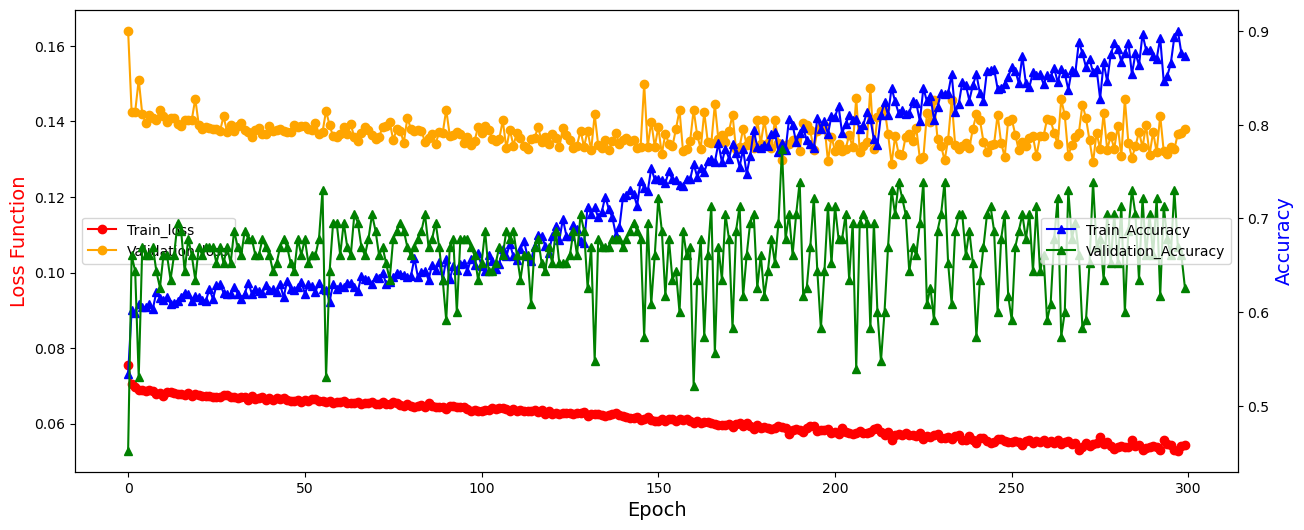

Current time: 118.900 minutes. Time expected till completion: 79.267 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.05538385455105706
Val loss:  0.14048766053241232
train accuracy:  0.8433268858800773
Val accuracy:  0.6347826086956522
Current time: 119.296 minutes. Time expected till completion: 78.870 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.05394833490281317
Val loss:  0.13845634875090226
train accuracy:  0.8684719535783365
Val accuracy:  0.6086956521739131
Current time: 119.693 minutes. Time expected till completion: 78.474 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.05318428688399796
Val loss:  0.13978263087894605
train accuracy:  0.8907156673114119
Val accuracy:  0.6347826086956522
Current time: 120.091 minutes. Time expected till completion: 78.079 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.053252797177497375
Val loss:  0.13534152974253116
train accuracy:  0.8897485493230174
Val accuracy:  0.6521739130434783
Current time: 120.484 minutes. Time expected till completion: 77.680 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:01<00:00, 11.99it/s]


train loss:  0.05331352168632891
Val loss:  0.13716902525528618
train accuracy:  0.8858800773694391
Val accuracy:  0.6869565217391305
Current time: 120.898 minutes. Time expected till completion: 77.296 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


train loss:  0.05244762224201077
Val loss:  0.14295185286065806
train accuracy:  0.9042553191489362
Val accuracy:  0.591304347826087
Current time: 121.317 minutes. Time expected till completion: 76.913 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


train loss:  0.05287265374074822
Val loss:  0.13333711313164753
train accuracy:  0.8916827852998066
Val accuracy:  0.6956521739130435
Current time: 121.716 minutes. Time expected till completion: 76.519 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:01<00:00, 12.60it/s]


train loss:  0.052892118865332245
Val loss:  0.13444022562192834
train accuracy:  0.8965183752417795
Val accuracy:  0.7043478260869566
Current time: 122.119 minutes. Time expected till completion: 76.126 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


train loss:  0.05294344912875782
Val loss:  0.13305481361306232
train accuracy:  0.8955512572533849
Val accuracy:  0.6782608695652174
Current time: 122.541 minutes. Time expected till completion: 75.745 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:01<00:00, 13.76it/s]


train loss:  0.054079974873614725
Val loss:  0.13258870321771374
train accuracy:  0.8704061895551257
Val accuracy:  0.6869565217391305
Current time: 122.933 minutes. Time expected till completion: 75.346 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


train loss:  0.05322828981124686
Val loss:  0.13452282625695933
train accuracy:  0.8907156673114119
Val accuracy:  0.6782608695652174
Current time: 123.330 minutes. Time expected till completion: 74.950 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.053307598229764275
Val loss:  0.13612102892087855
train accuracy:  0.8878143133462283
Val accuracy:  0.6956521739130435
Current time: 123.732 minutes. Time expected till completion: 74.557 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.05344396766195906
Val loss:  0.13614437683768896
train accuracy:  0.8858800773694391
Val accuracy:  0.6608695652173913
Current time: 124.125 minutes. Time expected till completion: 74.158 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


train loss:  0.053786541956766895
Val loss:  0.13567348666813062
train accuracy:  0.8839458413926499
Val accuracy:  0.6695652173913044
Current time: 124.521 minutes. Time expected till completion: 73.761 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.05335065491886618
Val loss:  0.14137891064519467
train accuracy:  0.8878143133462283
Val accuracy:  0.6
Current time: 124.915 minutes. Time expected till completion: 73.363 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:01<00:00, 13.89it/s]


train loss:  0.05331567875190676
Val loss:  0.14557108516278475
train accuracy:  0.8897485493230174
Val accuracy:  0.6
Current time: 125.323 minutes. Time expected till completion: 72.973 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.05154216577743884
Val loss:  0.1354092432105023
train accuracy:  0.9158607350096711
Val accuracy:  0.6869565217391305
Current time: 125.720 minutes. Time expected till completion: 72.577 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.05309263015854059
Val loss:  0.14014983747316442
train accuracy:  0.8878143133462283
Val accuracy:  0.6608695652173913
Current time: 126.113 minutes. Time expected till completion: 72.178 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.05237667461428467
Val loss:  0.13975362363068955
train accuracy:  0.9081237911025145
Val accuracy:  0.6434782608695652
Current time: 126.515 minutes. Time expected till completion: 71.784 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.053189980107534326
Val loss:  0.13833331076995187
train accuracy:  0.8849129593810445
Val accuracy:  0.6608695652173913
Current time: 126.907 minutes. Time expected till completion: 71.385 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


train loss:  0.053330954027360364
Val loss:  0.14692515964093417
train accuracy:  0.8829787234042553
Val accuracy:  0.591304347826087
Current time: 127.304 minutes. Time expected till completion: 70.989 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:01<00:00, 13.62it/s]


train loss:  0.05287057553315301
Val loss:  0.1389691166255785
train accuracy:  0.8945841392649904
Val accuracy:  0.6695652173913044
Current time: 127.696 minutes. Time expected till completion: 70.590 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


train loss:  0.05252262696306756
Val loss:  0.14002664192863132
train accuracy:  0.8936170212765957
Val accuracy:  0.6608695652173913
Current time: 128.116 minutes. Time expected till completion: 70.206 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.052786084450421066
Val loss:  0.1347970687824747
train accuracy:  0.8965183752417795
Val accuracy:  0.6695652173913044
Current time: 128.542 minutes. Time expected till completion: 69.825 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:01<00:00, 12.13it/s]


train loss:  0.052726976991391505
Val loss:  0.13789604539456574
train accuracy:  0.8984526112185687
Val accuracy:  0.6608695652173913
Current time: 128.979 minutes. Time expected till completion: 69.450 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.053555716167796745
Val loss:  0.14052245150441708
train accuracy:  0.879110251450677
Val accuracy:  0.6434782608695652
Current time: 129.386 minutes. Time expected till completion: 69.059 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:01<00:00, 13.49it/s]


train loss:  0.05291063175671797
Val loss:  0.13315410458523294
train accuracy:  0.8916827852998066
Val accuracy:  0.6869565217391305
Current time: 129.795 minutes. Time expected till completion: 68.669 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:01<00:00, 12.99it/s]


train loss:  0.05234431569073601
Val loss:  0.134332187279411
train accuracy:  0.9003868471953579
Val accuracy:  0.6782608695652174
Current time: 130.203 minutes. Time expected till completion: 68.277 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:01<00:00, 13.42it/s]


train loss:  0.05222898606405498
Val loss:  0.13533603834069294
train accuracy:  0.9052224371373307
Val accuracy:  0.6782608695652174
Current time: 130.609 minutes. Time expected till completion: 67.885 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


train loss:  0.05230198964851276
Val loss:  0.14569264443024346
train accuracy:  0.9081237911025145
Val accuracy:  0.6260869565217392
Current time: 131.020 minutes. Time expected till completion: 67.495 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.05322027644520802
Val loss:  0.13612419263176295
train accuracy:  0.8810444874274661
Val accuracy:  0.6695652173913044
Current time: 131.426 minutes. Time expected till completion: 67.103 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:01<00:00, 13.23it/s]


train loss:  0.053388088826284645
Val loss:  0.13963448223860367
train accuracy:  0.8829787234042553
Val accuracy:  0.6347826086956522
Current time: 131.831 minutes. Time expected till completion: 66.710 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:01<00:00, 12.84it/s]


train loss:  0.05347582547992064
Val loss:  0.13909383286600527
train accuracy:  0.8810444874274661
Val accuracy:  0.6521739130434783
Current time: 132.243 minutes. Time expected till completion: 66.320 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.05316963255751295
Val loss:  0.1346911202306333
train accuracy:  0.8945841392649904
Val accuracy:  0.6956521739130435
Current time: 132.657 minutes. Time expected till completion: 65.932 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.052857538256469966
Val loss:  0.130737202582152
train accuracy:  0.8974854932301741
Val accuracy:  0.7217391304347827
Current time: 133.052 minutes. Time expected till completion: 65.533 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


train loss:  0.05178509926427033
Val loss:  0.1388709166775579
train accuracy:  0.90715667311412
Val accuracy:  0.6347826086956522
Current time: 133.457 minutes. Time expected till completion: 65.140 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


train loss:  0.052184296415207235
Val loss:  0.13710844620414403
train accuracy:  0.90715667311412
Val accuracy:  0.6782608695652174
Current time: 133.883 minutes. Time expected till completion: 64.757 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:01<00:00, 13.25it/s]


train loss:  0.05219073804019729
Val loss:  0.13414817374685536
train accuracy:  0.9032882011605415
Val accuracy:  0.7130434782608696
Current time: 134.296 minutes. Time expected till completion: 64.367 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  0.05186559597113146
Val loss:  0.13820060750712518
train accuracy:  0.913926499032882
Val accuracy:  0.6608695652173913
Current time: 134.697 minutes. Time expected till completion: 63.971 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.05303667598121171
Val loss:  0.1354138353596563
train accuracy:  0.8839458413926499
Val accuracy:  0.6956521739130435
Current time: 135.106 minutes. Time expected till completion: 63.579 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:01<00:00, 12.69it/s]


train loss:  0.05176103824111894
Val loss:  0.1377936223278875
train accuracy:  0.9148936170212766
Val accuracy:  0.6434782608695652
Current time: 135.516 minutes. Time expected till completion: 63.188 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:01<00:00, 13.75it/s]


train loss:  0.05194663211732123
Val loss:  0.1430656707805136
train accuracy:  0.9110251450676983
Val accuracy:  0.6173913043478261
Current time: 135.925 minutes. Time expected till completion: 62.796 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:01<00:00, 13.11it/s]


train loss:  0.05221331857389823
Val loss:  0.14604016024133434
train accuracy:  0.9081237911025145
Val accuracy:  0.5652173913043478
Current time: 136.325 minutes. Time expected till completion: 62.400 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:01<00:00, 13.84it/s]


train loss:  0.05272967170931154
Val loss:  0.1326029419898987
train accuracy:  0.8897485493230174
Val accuracy:  0.6869565217391305
Current time: 136.723 minutes. Time expected till completion: 62.002 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


train loss:  0.051842227145827716
Val loss:  0.13358292890631634
train accuracy:  0.9119922630560928
Val accuracy:  0.7043478260869566
Current time: 137.130 minutes. Time expected till completion: 61.609 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


train loss:  0.051928287029727516
Val loss:  0.14012131794639257
train accuracy:  0.9177949709864603
Val accuracy:  0.6521739130434783
Current time: 137.541 minutes. Time expected till completion: 61.218 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:01<00:00, 13.23it/s]


train loss:  0.05222699847396615
Val loss:  0.1322355990824492
train accuracy:  0.9061895551257253
Val accuracy:  0.7043478260869566
Current time: 137.941 minutes. Time expected till completion: 60.821 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.05231301979354548
Val loss:  0.13655167144277822
train accuracy:  0.90715667311412
Val accuracy:  0.6347826086956522
Current time: 138.346 minutes. Time expected till completion: 60.427 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:01<00:00, 12.39it/s]


train loss:  0.05205353685227768
Val loss:  0.13121268697406935
train accuracy:  0.9100580270793037
Val accuracy:  0.7304347826086957
Current time: 138.756 minutes. Time expected till completion: 60.035 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.05230813976413277
Val loss:  0.1284337308095849
train accuracy:  0.902321083172147
Val accuracy:  0.7391304347826086
Current time: 139.152 minutes. Time expected till completion: 59.637 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.05096065859730055
Val loss:  0.13822855275610219
train accuracy:  0.9274661508704062
Val accuracy:  0.6782608695652174
Current time: 139.555 minutes. Time expected till completion: 59.241 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.0510813859030172
Val loss:  0.13661900603252908
train accuracy:  0.9235976789168279
Val accuracy:  0.6521739130434783
Current time: 139.961 minutes. Time expected till completion: 58.847 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.05191284412341607
Val loss:  0.13561987462251082
train accuracy:  0.9187620889748549
Val accuracy:  0.7043478260869566
Current time: 140.356 minutes. Time expected till completion: 58.448 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.052047946755152834
Val loss:  0.1356739261875982
train accuracy:  0.9129593810444874
Val accuracy:  0.6608695652173913
Current time: 140.766 minutes. Time expected till completion: 58.056 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:01<00:00, 13.70it/s]


train loss:  0.05118777304599548
Val loss:  0.1416343004807182
train accuracy:  0.9274661508704062
Val accuracy:  0.6
Current time: 141.191 minutes. Time expected till completion: 57.670 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


train loss:  0.05134576466835214
Val loss:  0.15108313767806344
train accuracy:  0.9274661508704062
Val accuracy:  0.5478260869565217
Current time: 141.621 minutes. Time expected till completion: 57.285 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:01<00:00, 13.18it/s]


train loss:  0.05152899234391734
Val loss:  0.13301767214484836
train accuracy:  0.9226305609284333
Val accuracy:  0.6956521739130435
Current time: 142.038 minutes. Time expected till completion: 56.895 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:01<00:00, 12.38it/s]


train loss:  0.05246591043426174
Val loss:  0.13751594294672426
train accuracy:  0.9032882011605415
Val accuracy:  0.6869565217391305
Current time: 142.461 minutes. Time expected till completion: 56.507 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:01<00:00, 12.80it/s]


train loss:  0.0523541436550465
Val loss:  0.13743018326552017
train accuracy:  0.9032882011605415
Val accuracy:  0.6782608695652174
Current time: 142.911 minutes. Time expected till completion: 56.130 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:01<00:00, 13.02it/s]


train loss:  0.05202297114080802
Val loss:  0.13738466345745584
train accuracy:  0.9081237911025145
Val accuracy:  0.6608695652173913
Current time: 143.326 minutes. Time expected till completion: 55.738 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.05132282454686193
Val loss:  0.14220666004263838
train accuracy:  0.9187620889748549
Val accuracy:  0.6260869565217392
Current time: 143.759 minutes. Time expected till completion: 55.353 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.05157109829858378
Val loss:  0.14108092733051467
train accuracy:  0.9129593810444874
Val accuracy:  0.6347826086956522
Current time: 144.173 minutes. Time expected till completion: 54.961 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


train loss:  0.05230341952589541
Val loss:  0.13353243496107017
train accuracy:  0.9013539651837524
Val accuracy:  0.6608695652173913
Current time: 144.583 minutes. Time expected till completion: 54.567 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


train loss:  0.05202825364568478
Val loss:  0.13180492442587147
train accuracy:  0.9129593810444874
Val accuracy:  0.7304347826086957
Current time: 145.005 minutes. Time expected till completion: 54.178 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:01<00:00, 13.15it/s]


train loss:  0.05125397190134576
Val loss:  0.13585640762163245
train accuracy:  0.925531914893617
Val accuracy:  0.6869565217391305
Current time: 145.423 minutes. Time expected till completion: 53.787 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.052334146181434914
Val loss:  0.13919954818228017
train accuracy:  0.8984526112185687
Val accuracy:  0.6086956521739131
Current time: 145.832 minutes. Time expected till completion: 53.392 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:01<00:00, 13.69it/s]


train loss:  0.051318916119274825
Val loss:  0.1325319881024568
train accuracy:  0.9274661508704062
Val accuracy:  0.6869565217391305
Current time: 146.255 minutes. Time expected till completion: 53.002 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:01<00:00, 12.93it/s]


train loss:  0.051668607577595074
Val loss:  0.13077643539594566
train accuracy:  0.9129593810444874
Val accuracy:  0.7304347826086957
Current time: 146.656 minutes. Time expected till completion: 52.605 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  0.051983232943186214
Val loss:  0.13697471722312596
train accuracy:  0.9061895551257253
Val accuracy:  0.6695652173913044
Current time: 147.067 minutes. Time expected till completion: 52.211 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.05131619442362389
Val loss:  0.1373361084772193
train accuracy:  0.9216634429400387
Val accuracy:  0.6869565217391305
Current time: 147.479 minutes. Time expected till completion: 51.817 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:01<00:00, 13.37it/s]


train loss:  0.051585639583764734
Val loss:  0.1391915176225745
train accuracy:  0.9177949709864603
Val accuracy:  0.6521739130434783
Current time: 147.888 minutes. Time expected till completion: 51.422 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:01<00:00, 13.34it/s]


train loss:  0.05141182609868004
Val loss:  0.1332731236582217
train accuracy:  0.9235976789168279
Val accuracy:  0.7043478260869566
Current time: 148.298 minutes. Time expected till completion: 51.027 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:01<00:00, 13.57it/s]


train loss:  0.0517724851575073
Val loss:  0.13758359007213428
train accuracy:  0.9100580270793037
Val accuracy:  0.6695652173913044
Current time: 148.719 minutes. Time expected till completion: 50.636 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


train loss:  0.051052581641383515
Val loss:  0.14010300584461377
train accuracy:  0.9264990328820116
Val accuracy:  0.6521739130434783
Current time: 149.124 minutes. Time expected till completion: 50.240 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.05149129171436022
Val loss:  0.14137110295503036
train accuracy:  0.9187620889748549
Val accuracy:  0.6173913043478261
Current time: 149.524 minutes. Time expected till completion: 49.841 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:01<00:00, 13.21it/s]


train loss:  0.05105637622064041
Val loss:  0.1348224199336508
train accuracy:  0.9274661508704062
Val accuracy:  0.6782608695652174
Current time: 149.933 minutes. Time expected till completion: 49.446 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.051030416437920105
Val loss:  0.13413241479707802
train accuracy:  0.9235976789168279
Val accuracy:  0.6695652173913044
Current time: 150.359 minutes. Time expected till completion: 49.056 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:01<00:00, 13.82it/s]


train loss:  0.0512548891441965
Val loss:  0.13501639210659525
train accuracy:  0.9187620889748549
Val accuracy:  0.6956521739130435
Current time: 150.788 minutes. Time expected till completion: 48.667 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.05170030537380241
Val loss:  0.13240904704384182
train accuracy:  0.9119922630560928
Val accuracy:  0.7217391304347827
Current time: 151.191 minutes. Time expected till completion: 48.269 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:01<00:00, 13.73it/s]


train loss:  0.05096009298726715
Val loss:  0.1334705316502115
train accuracy:  0.9284332688588007
Val accuracy:  0.6956521739130435
Current time: 151.597 minutes. Time expected till completion: 47.873 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:01<00:00, 13.42it/s]


train loss:  0.05072284102209301
Val loss:  0.13665336681448895
train accuracy:  0.9342359767891683
Val accuracy:  0.6695652173913044
Current time: 152.011 minutes. Time expected till completion: 47.479 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:01<00:00, 11.93it/s]


train loss:  0.050877609151474976
Val loss:  0.13919617715089216
train accuracy:  0.9323017408123792
Val accuracy:  0.6695652173913044
Current time: 152.431 minutes. Time expected till completion: 47.086 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:01<00:00, 11.99it/s]


train loss:  0.051721233924998535
Val loss:  0.138567228420921
train accuracy:  0.9148936170212766
Val accuracy:  0.6434782608695652
Current time: 152.847 minutes. Time expected till completion: 46.692 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:01<00:00, 12.73it/s]


train loss:  0.05153422942475147
Val loss:  0.14240757589754852
train accuracy:  0.9158607350096711
Val accuracy:  0.6086956521739131
Current time: 153.271 minutes. Time expected till completion: 46.300 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.05145530376720244
Val loss:  0.1374967564707217
train accuracy:  0.9197292069632496
Val accuracy:  0.6521739130434783
Current time: 153.690 minutes. Time expected till completion: 45.907 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.0518920987671533
Val loss:  0.13641583142073258
train accuracy:  0.9061895551257253
Val accuracy:  0.6608695652173913
Current time: 154.108 minutes. Time expected till completion: 45.514 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:01<00:00, 13.11it/s]


train loss:  0.05138747512256615
Val loss:  0.13276089170704716
train accuracy:  0.9158607350096711
Val accuracy:  0.6956521739130435
Current time: 154.534 minutes. Time expected till completion: 45.122 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:01<00:00, 13.08it/s]


train loss:  0.0507442532125248
Val loss:  0.1355420179989027
train accuracy:  0.937137330754352
Val accuracy:  0.6956521739130435
Current time: 154.973 minutes. Time expected till completion: 44.735 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:01<00:00, 13.12it/s]


train loss:  0.050336138826274315
Val loss:  0.1309649197951607
train accuracy:  0.9361702127659575
Val accuracy:  0.7217391304347827
Current time: 155.401 minutes. Time expected till completion: 44.343 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:01<00:00, 10.63it/s]


train loss:  0.05048488296669272
Val loss:  0.1332708452058875
train accuracy:  0.9381044487427466
Val accuracy:  0.6956521739130435
Current time: 155.842 minutes. Time expected till completion: 43.955 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.050686800502946806
Val loss:  0.14045641059460848
train accuracy:  0.9352030947775629
Val accuracy:  0.6347826086956522
Current time: 156.268 minutes. Time expected till completion: 43.563 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:01<00:00, 13.67it/s]


train loss:  0.051188819124804705
Val loss:  0.14263366875441177
train accuracy:  0.9264990328820116
Val accuracy:  0.6521739130434783
Current time: 156.673 minutes. Time expected till completion: 43.165 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.05120853494629408
Val loss:  0.14157676333966462
train accuracy:  0.9245647969052224
Val accuracy:  0.6608695652173913
Current time: 157.078 minutes. Time expected till completion: 42.767 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:01<00:00, 13.80it/s]


train loss:  0.05106619392419
Val loss:  0.1350744998973349
train accuracy:  0.9216634429400387
Val accuracy:  0.6869565217391305
Current time: 157.489 minutes. Time expected till completion: 42.370 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:01<00:00, 12.83it/s]


train loss:  0.05098922461328931
Val loss:  0.13376497030258178
train accuracy:  0.9332688588007737
Val accuracy:  0.6869565217391305
Current time: 157.892 minutes. Time expected till completion: 41.971 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:01<00:00, 13.39it/s]


train loss:  0.05064088244502733
Val loss:  0.13631102209505827
train accuracy:  0.9390715667311412
Val accuracy:  0.6869565217391305
Current time: 158.318 minutes. Time expected till completion: 41.578 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


train loss:  0.05081196247493736
Val loss:  0.1363134959469671
train accuracy:  0.9303675048355899
Val accuracy:  0.6608695652173913
Current time: 158.725 minutes. Time expected till completion: 41.181 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


train loss:  0.051055518697723894
Val loss:  0.13369465185248333
train accuracy:  0.9264990328820116
Val accuracy:  0.7043478260869566
Current time: 159.141 minutes. Time expected till completion: 40.785 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:01<00:00, 12.66it/s]


train loss:  0.051031241276278026
Val loss:  0.1311025365539219
train accuracy:  0.9274661508704062
Val accuracy:  0.7043478260869566
Current time: 159.576 minutes. Time expected till completion: 40.394 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


train loss:  0.05036748037808638
Val loss:  0.13800681311151256
train accuracy:  0.9400386847195358
Val accuracy:  0.6608695652173913
Saving model checkpoint


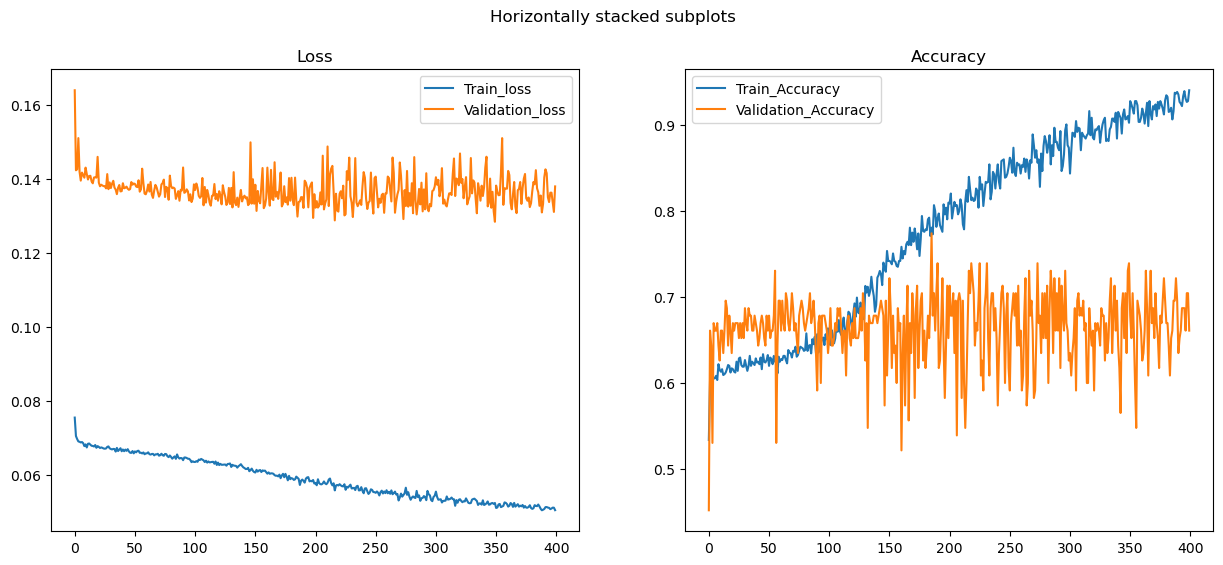

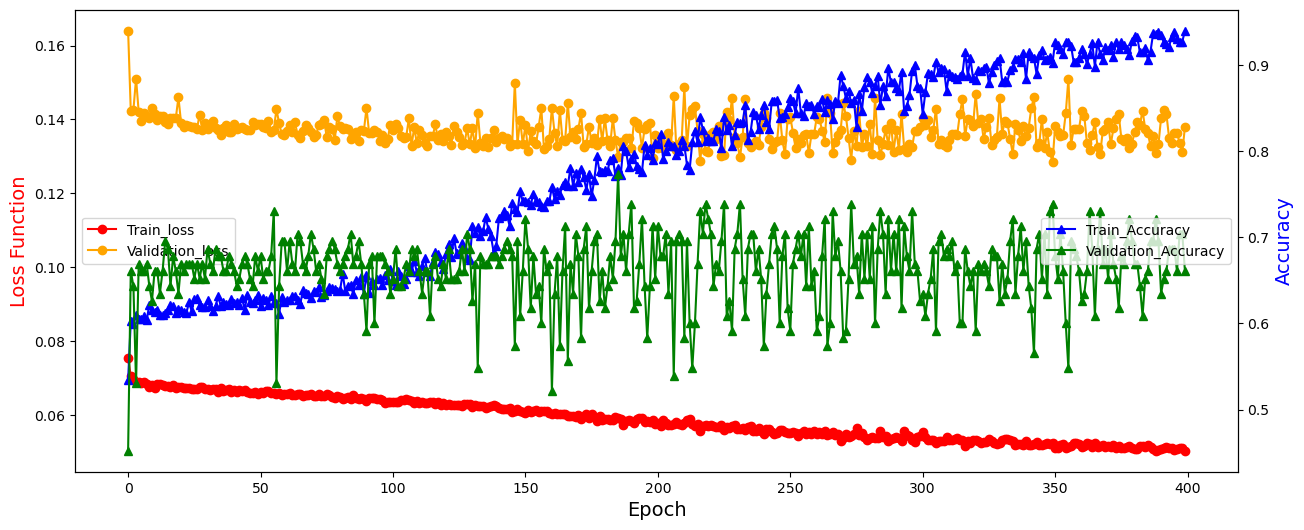

Current time: 160.100 minutes. Time expected till completion: 40.025 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.05075664066023246
Val loss:  0.13776645556740139
train accuracy:  0.9352030947775629
Val accuracy:  0.6782608695652174
Current time: 160.510 minutes. Time expected till completion: 39.627 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.0511595537630225
Val loss:  0.129961779843206
train accuracy:  0.9226305609284333
Val accuracy:  0.7391304347826086
Current time: 160.935 minutes. Time expected till completion: 39.233 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:01<00:00, 13.10it/s]


train loss:  0.05044548135661525
Val loss:  0.1310701038526452
train accuracy:  0.9323017408123792
Val accuracy:  0.7304347826086957
Current time: 161.348 minutes. Time expected till completion: 38.836 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:01<00:00, 13.87it/s]


train loss:  0.05011042819954671
Val loss:  0.138327986261119
train accuracy:  0.9400386847195358
Val accuracy:  0.6956521739130435
Current time: 161.746 minutes. Time expected till completion: 38.435 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.05054358339632503
Val loss:  0.13787082537360815
train accuracy:  0.937137330754352
Val accuracy:  0.6782608695652174
Current time: 162.160 minutes. Time expected till completion: 38.037 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.051212800367657865
Val loss:  0.13804027308588443
train accuracy:  0.9245647969052224
Val accuracy:  0.6869565217391305
Current time: 162.591 minutes. Time expected till completion: 37.644 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:01<00:00, 13.20it/s]


train loss:  0.05099629174118116
Val loss:  0.13811374436254087
train accuracy:  0.9284332688588007
Val accuracy:  0.6782608695652174
Current time: 163.006 minutes. Time expected till completion: 37.247 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:01<00:00, 12.95it/s]


train loss:  0.05122425195326888
Val loss:  0.14412218746931657
train accuracy:  0.9177949709864603
Val accuracy:  0.6260869565217392
Current time: 163.419 minutes. Time expected till completion: 36.849 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:01<00:00, 13.14it/s]


train loss:  0.05170456186023395
Val loss:  0.13500069379806517
train accuracy:  0.9158607350096711
Val accuracy:  0.6869565217391305
Current time: 163.832 minutes. Time expected till completion: 36.452 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.05060282193945732
Val loss:  0.13757996714633444
train accuracy:  0.937137330754352
Val accuracy:  0.6869565217391305
Current time: 164.245 minutes. Time expected till completion: 36.054 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.05100791280228119
Val loss:  0.1356723655825076
train accuracy:  0.9245647969052224
Val accuracy:  0.6782608695652174
Current time: 164.661 minutes. Time expected till completion: 35.657 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:01<00:00, 13.13it/s]


train loss:  0.05028391679896607
Val loss:  0.13839215454847917
train accuracy:  0.9439071566731141
Val accuracy:  0.6608695652173913
Current time: 165.065 minutes. Time expected till completion: 35.257 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:01<00:00, 13.33it/s]


train loss:  0.0500070437126049
Val loss:  0.13256281147832455
train accuracy:  0.9477756286266924
Val accuracy:  0.7130434782608696
Current time: 165.480 minutes. Time expected till completion: 34.859 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:01<00:00, 13.15it/s]


train loss:  0.050209725848480165
Val loss:  0.13302688080331554
train accuracy:  0.9439071566731141
Val accuracy:  0.7130434782608696
Current time: 165.889 minutes. Time expected till completion: 34.460 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:01<00:00, 13.51it/s]


train loss:  0.05032909809966613
Val loss:  0.13208866845006528
train accuracy:  0.9410058027079303
Val accuracy:  0.7043478260869566
Current time: 166.301 minutes. Time expected till completion: 34.062 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:01<00:00, 13.34it/s]


train loss:  0.05133412072229662
Val loss:  0.13549717820209006
train accuracy:  0.9187620889748549
Val accuracy:  0.6956521739130435
Current time: 166.719 minutes. Time expected till completion: 33.664 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:01<00:00, 13.36it/s]


train loss:  0.05039988541741436
Val loss:  0.1380448781925699
train accuracy:  0.9381044487427466
Val accuracy:  0.6695652173913044
Current time: 167.140 minutes. Time expected till completion: 33.268 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


train loss:  0.04980570994447232
Val loss:  0.1348885178565979
train accuracy:  0.9506769825918762
Val accuracy:  0.7043478260869566
Current time: 167.557 minutes. Time expected till completion: 32.870 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:01<00:00, 13.34it/s]


train loss:  0.05053279339921313
Val loss:  0.13569890675337418
train accuracy:  0.9313346228239845
Val accuracy:  0.6695652173913044
Current time: 167.961 minutes. Time expected till completion: 32.470 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:01<00:00, 13.26it/s]


train loss:  0.05015482495555103
Val loss:  0.13565850413363914
train accuracy:  0.941972920696325
Val accuracy:  0.6782608695652174
Current time: 168.383 minutes. Time expected till completion: 32.073 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.050498294357635524
Val loss:  0.1405515758887581
train accuracy:  0.9313346228239845
Val accuracy:  0.6434782608695652
Current time: 168.795 minutes. Time expected till completion: 31.674 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:01<00:00, 13.24it/s]


train loss:  0.05110687916698493
Val loss:  0.13290559882703035
train accuracy:  0.9284332688588007
Val accuracy:  0.6956521739130435
Current time: 169.214 minutes. Time expected till completion: 31.276 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:01<00:00, 12.89it/s]


train loss:  0.05068727313204015
Val loss:  0.13376076739767323
train accuracy:  0.9381044487427466
Val accuracy:  0.7130434782608696
Current time: 169.629 minutes. Time expected till completion: 30.878 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.05130084985921184
Val loss:  0.1366155328957931
train accuracy:  0.9216634429400387
Val accuracy:  0.6869565217391305
Current time: 170.035 minutes. Time expected till completion: 30.478 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:01<00:00, 12.74it/s]


train loss:  0.05147386894235297
Val loss:  0.13703709737114284
train accuracy:  0.9206963249516441
Val accuracy:  0.6695652173913044
Current time: 170.438 minutes. Time expected till completion: 30.077 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.05038816659086216
Val loss:  0.13588630168334298
train accuracy:  0.9410058027079303
Val accuracy:  0.7043478260869566
Current time: 170.849 minutes. Time expected till completion: 29.678 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:01<00:00, 13.11it/s]


train loss:  0.05030957394688457
Val loss:  0.13863118005835492
train accuracy:  0.9390715667311412
Val accuracy:  0.6695652173913044
Current time: 171.288 minutes. Time expected till completion: 29.283 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:01<00:00, 13.66it/s]


train loss:  0.051089361569406445
Val loss:  0.13127283635346787
train accuracy:  0.9294003868471954
Val accuracy:  0.7130434782608696
Current time: 171.696 minutes. Time expected till completion: 28.883 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:01<00:00, 13.32it/s]


train loss:  0.050089922933560044
Val loss:  0.1377994972726573
train accuracy:  0.941972920696325
Val accuracy:  0.6695652173913044
Current time: 172.115 minutes. Time expected till completion: 28.485 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:01<00:00, 13.31it/s]


train loss:  0.050205965049031624
Val loss:  0.136101700430331
train accuracy:  0.9439071566731141
Val accuracy:  0.6869565217391305
Current time: 172.536 minutes. Time expected till completion: 28.087 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.05064164479650427
Val loss:  0.13930741496708082
train accuracy:  0.9313346228239845
Val accuracy:  0.6782608695652174
Current time: 172.943 minutes. Time expected till completion: 27.687 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:01<00:00, 12.34it/s]


train loss:  0.04999738747192767
Val loss:  0.1412730942601743
train accuracy:  0.9458413926499033
Val accuracy:  0.6086956521739131
Current time: 173.366 minutes. Time expected till completion: 27.289 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:01<00:00, 13.52it/s]


train loss:  0.05043737264620266
Val loss:  0.13810346541197405
train accuracy:  0.9332688588007737
Val accuracy:  0.6434782608695652
Current time: 173.784 minutes. Time expected till completion: 26.890 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:01<00:00, 12.16it/s]


train loss:  0.049685958160422525
Val loss:  0.13456245246140852
train accuracy:  0.9516441005802708
Val accuracy:  0.6956521739130435
Current time: 174.196 minutes. Time expected till completion: 26.491 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:01<00:00, 13.63it/s]


train loss:  0.050292443433628785
Val loss:  0.13759269921675973
train accuracy:  0.9429400386847195
Val accuracy:  0.6782608695652174
Current time: 174.621 minutes. Time expected till completion: 26.093 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:01<00:00, 12.18it/s]


train loss:  0.049924338117558906
Val loss:  0.14062864313954893
train accuracy:  0.9477756286266924
Val accuracy:  0.6521739130434783
Current time: 175.034 minutes. Time expected till completion: 25.693 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.05085519480751377
Val loss:  0.1515585660934448
train accuracy:  0.9323017408123792
Val accuracy:  0.5826086956521739
Current time: 175.446 minutes. Time expected till completion: 25.293 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:01<00:00, 13.52it/s]


train loss:  0.05152406297062075
Val loss:  0.1495597015256467
train accuracy:  0.9245647969052224
Val accuracy:  0.5826086956521739
Current time: 175.869 minutes. Time expected till completion: 24.895 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:01<00:00, 13.28it/s]


train loss:  0.05300104675717234
Val loss:  0.13732317634250807
train accuracy:  0.8936170212765957
Val accuracy:  0.6695652173913044
Current time: 176.286 minutes. Time expected till completion: 24.495 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:01<00:00, 13.64it/s]


train loss:  0.050837616510040755
Val loss:  0.13818452099095221
train accuracy:  0.9323017408123792
Val accuracy:  0.6608695652173913
Current time: 176.709 minutes. Time expected till completion: 24.097 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:01<00:00, 12.48it/s]


train loss:  0.05079062136045046
Val loss:  0.14636965419935144
train accuracy:  0.9303675048355899
Val accuracy:  0.6173913043478261
Current time: 177.111 minutes. Time expected till completion: 23.695 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:01<00:00, 13.04it/s]


train loss:  0.050178440730853056
Val loss:  0.13189999435258948
train accuracy:  0.9468085106382979
Val accuracy:  0.7130434782608696
Current time: 177.538 minutes. Time expected till completion: 23.297 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:01<00:00, 13.06it/s]


train loss:  0.05115949208316766
Val loss:  0.1350655296574468
train accuracy:  0.9197292069632496
Val accuracy:  0.6869565217391305
Current time: 177.957 minutes. Time expected till completion: 22.897 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


train loss:  0.050336831946437545
Val loss:  0.13265360127324644
train accuracy:  0.9410058027079303
Val accuracy:  0.7304347826086957
Current time: 178.375 minutes. Time expected till completion: 22.498 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.05041785812009003
Val loss:  0.1488960120988929
train accuracy:  0.9390715667311412
Val accuracy:  0.5826086956521739
Current time: 178.782 minutes. Time expected till completion: 22.097 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:01<00:00, 13.18it/s]


train loss:  0.05109116342819406
Val loss:  0.13550979261812957
train accuracy:  0.9235976789168279
Val accuracy:  0.6608695652173913
Current time: 179.210 minutes. Time expected till completion: 21.698 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.05016485807743478
Val loss:  0.13044271054475204
train accuracy:  0.9400386847195358
Val accuracy:  0.7391304347826086
Current time: 179.624 minutes. Time expected till completion: 21.298 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:01<00:00, 12.96it/s]


train loss:  0.05030803800320948
Val loss:  0.13177120892897895
train accuracy:  0.9400386847195358
Val accuracy:  0.7043478260869566
Current time: 180.074 minutes. Time expected till completion: 20.901 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.049501177420699156
Val loss:  0.1397928263830102
train accuracy:  0.9584139264990329
Val accuracy:  0.6608695652173913
Current time: 180.487 minutes. Time expected till completion: 20.501 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.04988939924673601
Val loss:  0.13311702531317007
train accuracy:  0.9477756286266924
Val accuracy:  0.6956521739130435
Current time: 180.898 minutes. Time expected till completion: 20.100 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:01<00:00, 13.45it/s]


train loss:  0.050540918423082656
Val loss:  0.13046632590501206
train accuracy:  0.9323017408123792
Val accuracy:  0.7391304347826086
Current time: 181.305 minutes. Time expected till completion: 19.698 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:01<00:00, 13.49it/s]


train loss:  0.05020233844650091
Val loss:  0.13205714847730554
train accuracy:  0.9429400386847195
Val accuracy:  0.6956521739130435
Current time: 181.709 minutes. Time expected till completion: 19.297 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:01<00:00, 12.10it/s]


train loss:  0.05038358758219898
Val loss:  0.12735629651857458
train accuracy:  0.9352030947775629
Val accuracy:  0.7565217391304347
Current time: 182.118 minutes. Time expected till completion: 18.895 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:01<00:00, 13.48it/s]


train loss:  0.05074580258742061
Val loss:  0.1381573832553366
train accuracy:  0.9332688588007737
Val accuracy:  0.6608695652173913
Current time: 182.528 minutes. Time expected till completion: 18.494 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:01<00:00, 13.58it/s]


train loss:  0.05087930696153548
Val loss:  0.13659486355988876
train accuracy:  0.9303675048355899
Val accuracy:  0.6695652173913044
Current time: 182.938 minutes. Time expected till completion: 18.093 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:01<00:00, 12.56it/s]


train loss:  0.05147593083649124
Val loss:  0.14436963330144467
train accuracy:  0.9197292069632496
Val accuracy:  0.6086956521739131
Current time: 183.368 minutes. Time expected till completion: 17.693 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:01<00:00, 12.78it/s]


train loss:  0.050535502297735305
Val loss:  0.13832673663678377
train accuracy:  0.9313346228239845
Val accuracy:  0.6521739130434783
Current time: 183.808 minutes. Time expected till completion: 17.295 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:01<00:00, 12.42it/s]


train loss:  0.04970973989488539
Val loss:  0.1336571631224259
train accuracy:  0.9506769825918762
Val accuracy:  0.6869565217391305
Current time: 184.233 minutes. Time expected till completion: 16.895 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:01<00:00, 13.59it/s]


train loss:  0.050070864838373266
Val loss:  0.13656443409297778
train accuracy:  0.941972920696325
Val accuracy:  0.6869565217391305
Current time: 184.685 minutes. Time expected till completion: 16.497 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:01<00:00, 13.34it/s]


train loss:  0.049864363105430826
Val loss:  0.13583392371302067
train accuracy:  0.9477756286266924
Val accuracy:  0.7043478260869566
Current time: 185.102 minutes. Time expected till completion: 16.096 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:01<00:00, 13.27it/s]


train loss:  0.049186151712498766
Val loss:  0.14031488221624625
train accuracy:  0.9593810444874274
Val accuracy:  0.6521739130434783
Current time: 185.529 minutes. Time expected till completion: 15.695 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:01<00:00, 13.16it/s]


train loss:  0.049656526435966415
Val loss:  0.13497371051622473
train accuracy:  0.9545454545454546
Val accuracy:  0.7043478260869566
Current time: 185.945 minutes. Time expected till completion: 15.294 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:01<00:00, 12.67it/s]


train loss:  0.04998954202497029
Val loss:  0.1326077393863512
train accuracy:  0.9429400386847195
Val accuracy:  0.6956521739130435
Current time: 186.374 minutes. Time expected till completion: 14.894 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:01<00:00, 13.36it/s]


train loss:  0.049720194572636885
Val loss:  0.1313694020976191
train accuracy:  0.9516441005802708
Val accuracy:  0.7130434782608696
Current time: 186.809 minutes. Time expected till completion: 14.494 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:01<00:00, 12.46it/s]


train loss:  0.049579071295330554
Val loss:  0.13544538694879282
train accuracy:  0.9545454545454546
Val accuracy:  0.6869565217391305
Current time: 187.229 minutes. Time expected till completion: 14.093 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.05027875482920752
Val loss:  0.13180567129798557
train accuracy:  0.9429400386847195
Val accuracy:  0.7217391304347827
Current time: 187.645 minutes. Time expected till completion: 13.691 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:01<00:00, 12.23it/s]


train loss:  0.050100238629881604
Val loss:  0.13950305917988653
train accuracy:  0.9439071566731141
Val accuracy:  0.6782608695652174
Current time: 188.067 minutes. Time expected till completion: 13.290 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:01<00:00, 13.35it/s]


train loss:  0.04961900093108127
Val loss:  0.1360089053278384
train accuracy:  0.9545454545454546
Val accuracy:  0.6782608695652174
Current time: 188.479 minutes. Time expected till completion: 12.887 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.04951113923605913
Val loss:  0.13512570184210074
train accuracy:  0.9545454545454546
Val accuracy:  0.6782608695652174
Current time: 188.897 minutes. Time expected till completion: 12.486 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:01<00:00, 13.74it/s]


train loss:  0.04922396365401823
Val loss:  0.1376030066738958
train accuracy:  0.960348162475822
Val accuracy:  0.6869565217391305
Current time: 189.310 minutes. Time expected till completion: 12.084 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:01<00:00, 13.21it/s]


train loss:  0.04954116671873938
Val loss:  0.13370236728502358
train accuracy:  0.9545454545454546
Val accuracy:  0.7043478260869566
Current time: 189.720 minutes. Time expected till completion: 11.681 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:01<00:00, 13.73it/s]


train loss:  0.04901843311938834
Val loss:  0.13472793309584907
train accuracy:  0.9642166344294004
Val accuracy:  0.6869565217391305
Current time: 190.131 minutes. Time expected till completion: 11.279 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:01<00:00, 13.61it/s]


train loss:  0.05012075329195831
Val loss:  0.13571866595226786
train accuracy:  0.941972920696325
Val accuracy:  0.6869565217391305
Current time: 190.539 minutes. Time expected till completion: 10.876 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:01<00:00, 13.30it/s]


train loss:  0.049987667187961896
Val loss:  0.13315795349038165
train accuracy:  0.9468085106382979
Val accuracy:  0.7217391304347827
Current time: 190.954 minutes. Time expected till completion: 10.474 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:01<00:00, 13.08it/s]


train loss:  0.04998414273188238
Val loss:  0.13267819933269334
train accuracy:  0.9448742746615088
Val accuracy:  0.7391304347826086
Current time: 191.364 minutes. Time expected till completion: 10.072 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:01<00:00, 13.38it/s]


train loss:  0.04949214259014831
Val loss:  0.1403396989988244
train accuracy:  0.9555125725338491
Val accuracy:  0.6521739130434783
Current time: 191.785 minutes. Time expected till completion: 9.670 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:01<00:00, 13.54it/s]


train loss:  0.04978825362323562
Val loss:  0.14828755440919295
train accuracy:  0.9487427466150871
Val accuracy:  0.6086956521739131
Current time: 192.196 minutes. Time expected till completion: 9.267 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:01<00:00, 13.17it/s]


train loss:  0.05043170305700321
Val loss:  0.13400173083595607
train accuracy:  0.9381044487427466
Val accuracy:  0.7130434782608696
Current time: 192.611 minutes. Time expected till completion: 8.865 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:01<00:00, 13.05it/s]


train loss:  0.05008713598408136
Val loss:  0.1336108306179876
train accuracy:  0.9448742746615088
Val accuracy:  0.7130434782608696
Current time: 193.031 minutes. Time expected till completion: 8.463 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:01<00:00, 13.77it/s]


train loss:  0.049922831860916755
Val loss:  0.13249560231747834
train accuracy:  0.9477756286266924
Val accuracy:  0.6782608695652174
Current time: 193.432 minutes. Time expected till completion: 8.060 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:01<00:00, 12.74it/s]


train loss:  0.04954290730118521
Val loss:  0.1369011049685271
train accuracy:  0.9535783365570599
Val accuracy:  0.6956521739130435
Current time: 193.836 minutes. Time expected till completion: 7.657 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.04943415251645175
Val loss:  0.14100957279619963
train accuracy:  0.9564796905222437
Val accuracy:  0.6521739130434783
Current time: 194.254 minutes. Time expected till completion: 7.254 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:01<00:00, 13.52it/s]


train loss:  0.05062377775660797
Val loss:  0.14601219685181327
train accuracy:  0.9352030947775629
Val accuracy:  0.6
Current time: 194.671 minutes. Time expected till completion: 6.852 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:01<00:00, 13.46it/s]


train loss:  0.04987902313874353
Val loss:  0.1362731337547302
train accuracy:  0.9487427466150871
Val accuracy:  0.6782608695652174
Current time: 195.075 minutes. Time expected till completion: 6.449 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:01<00:00, 13.11it/s]


train loss:  0.049515781192761094
Val loss:  0.1416489020637844
train accuracy:  0.9555125725338491
Val accuracy:  0.6260869565217392
Current time: 195.481 minutes. Time expected till completion: 6.046 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:01<00:00, 13.22it/s]


train loss:  0.05024710562750265
Val loss:  0.14692374778830486
train accuracy:  0.9439071566731141
Val accuracy:  0.6
Current time: 195.899 minutes. Time expected till completion: 5.643 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:01<00:00, 12.47it/s]


train loss:  0.050121234798339166
Val loss:  0.1348844341609789
train accuracy:  0.9458413926499033
Val accuracy:  0.7043478260869566
Current time: 196.315 minutes. Time expected till completion: 5.240 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:01<00:00, 13.58it/s]


train loss:  0.0499421051438588
Val loss:  0.14260669946670532
train accuracy:  0.9439071566731141
Val accuracy:  0.5826086956521739
Current time: 196.734 minutes. Time expected till completion: 4.838 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:01<00:00, 13.56it/s]


train loss:  0.04976327535723349
Val loss:  0.13695153879082722
train accuracy:  0.9497098646034816
Val accuracy:  0.6869565217391305
Current time: 197.156 minutes. Time expected till completion: 4.435 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:01<00:00, 12.96it/s]


train loss:  0.049400401645748944
Val loss:  0.13952329055122706
train accuracy:  0.9555125725338491
Val accuracy:  0.6608695652173913
Current time: 197.578 minutes. Time expected till completion: 4.032 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:01<00:00, 13.65it/s]


train loss:  0.05095302095957374
Val loss:  0.13661308858705604
train accuracy:  0.9294003868471954
Val accuracy:  0.6695652173913044
Current time: 197.990 minutes. Time expected till completion: 3.629 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:01<00:00, 13.79it/s]


train loss:  0.05027351763308394
Val loss:  0.13964721327242643
train accuracy:  0.9390715667311412
Val accuracy:  0.6695652173913044
Current time: 198.397 minutes. Time expected till completion: 3.226 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:01<00:00, 13.72it/s]


train loss:  0.04924373031815431
Val loss:  0.13660868147145147
train accuracy:  0.9574468085106383
Val accuracy:  0.6956521739130435
Current time: 198.802 minutes. Time expected till completion: 2.823 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:01<00:00, 12.64it/s]


train loss:  0.051070361291877996
Val loss:  0.1340408672457156
train accuracy:  0.9226305609284333
Val accuracy:  0.7043478260869566
Current time: 199.216 minutes. Time expected till completion: 2.420 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:01<00:00, 13.44it/s]


train loss:  0.050969898181911596
Val loss:  0.13878468793371448
train accuracy:  0.9235976789168279
Val accuracy:  0.6521739130434783
Current time: 199.635 minutes. Time expected till completion: 2.017 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:01<00:00, 13.53it/s]


train loss:  0.0501758987138073
Val loss:  0.13758391556532487
train accuracy:  0.9400386847195358
Val accuracy:  0.6608695652173913
Current time: 200.054 minutes. Time expected till completion: 1.613 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:01<00:00, 13.68it/s]


train loss:  0.05014736111666755
Val loss:  0.14009405115376347
train accuracy:  0.9361702127659575
Val accuracy:  0.6695652173913044
Current time: 200.465 minutes. Time expected till completion: 1.210 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:01<00:00, 13.09it/s]


train loss:  0.04975935678417494
Val loss:  0.13806310529294222
train accuracy:  0.9487427466150871
Val accuracy:  0.6434782608695652
Current time: 200.874 minutes. Time expected till completion: 0.807 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:01<00:00, 13.60it/s]


train loss:  0.04933210481066307
Val loss:  0.13366065232650093
train accuracy:  0.9555125725338491
Val accuracy:  0.6869565217391305
Current time: 201.273 minutes. Time expected till completion: 0.403 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:01<00:00, 13.55it/s]


train loss:  0.04964819959791763
Val loss:  0.14539321246354475
train accuracy:  0.9516441005802708
Val accuracy:  0.6
Saving model checkpoint


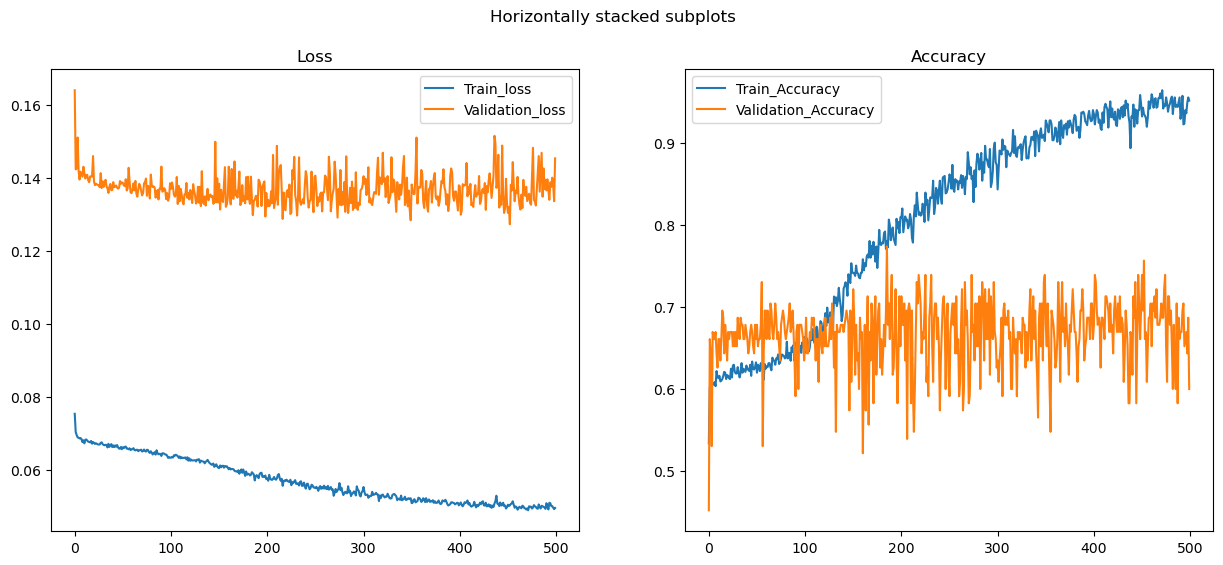

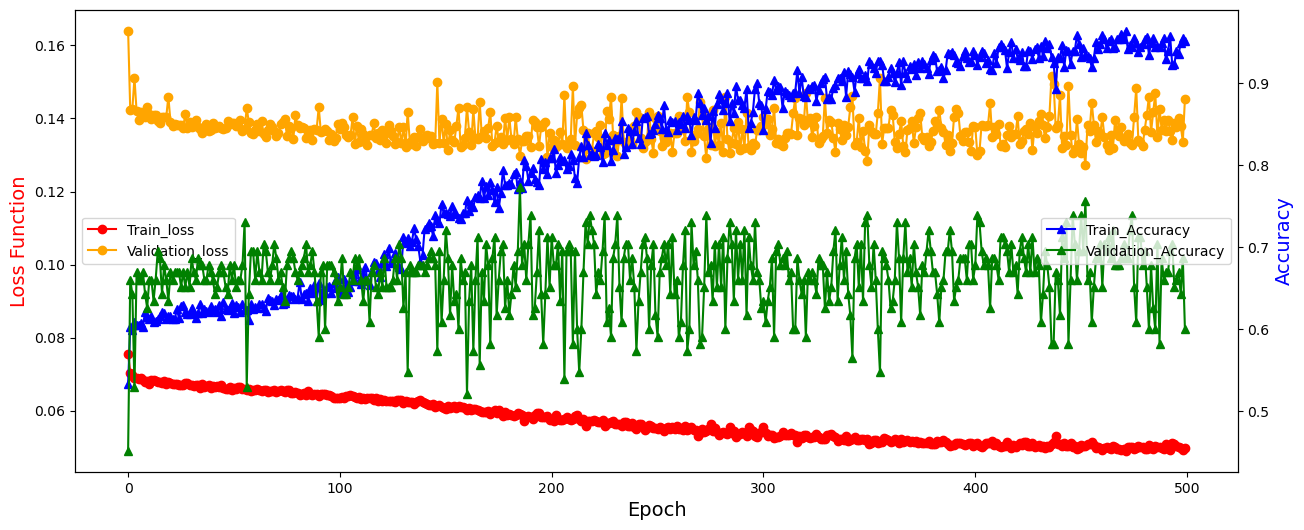

Current time: 201.831 minutes. Time expected till completion: 0.000 minutes
Finished training in: 201.831 minutes


In [15]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

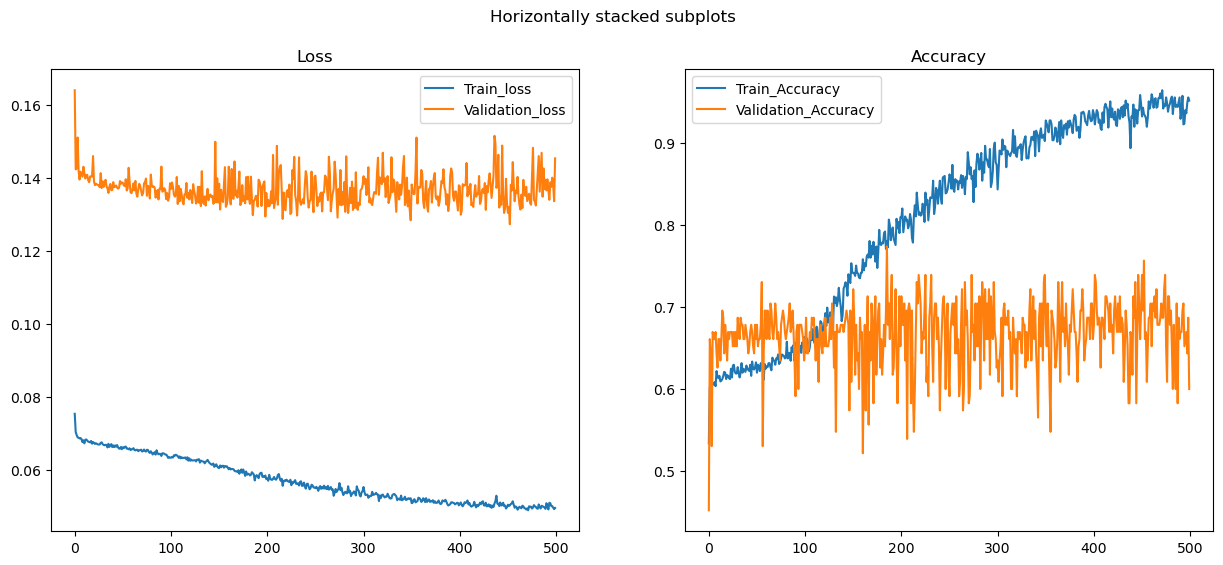

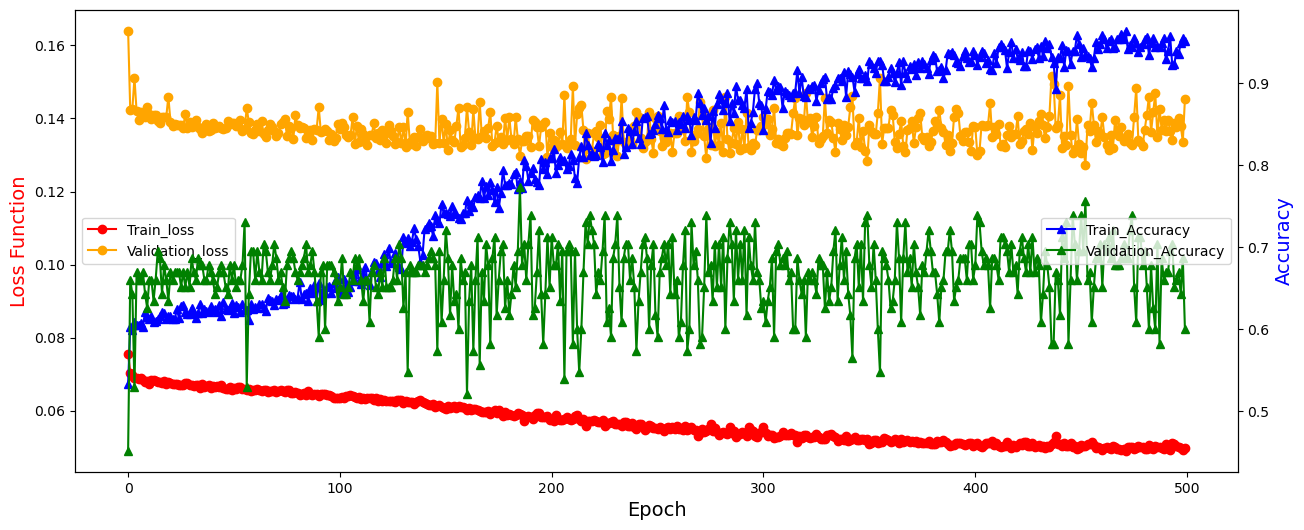

In [16]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [17]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [18]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 95.16441005802707%
Accuracy of the network on the 115 Validation instances: 60.0%


In [19]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [20]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [21]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [22]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="12_18Conv_0Res_128FChannels_6Batch.csv")

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points